# Honolulu rentals 


In [397]:
# import necessary libraries

import pandas as pd
from pandas import read_csv
from pandas.core.common import SettingWithCopyWarning

import numpy as np
from numpy import arange

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


from time import *
from random import randint

import xgboost as xgb
from xgboost import  XGBRegressor

import re

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None

# Data Acquisiton

The data will be scraped from the Craiglist housing website

In [398]:
"""# import necessary libraries
import requests
from bs4 import BeautifulSoup as bs

# specify the parameters of the browser settings
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}

# create a url list to scrape data from all pages
html = requests.get('https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa', headers = header)

#check status code, if 200 then continue
html.status_code"""

"# import necessary libraries\nimport requests\nfrom bs4 import BeautifulSoup as bs\n\n# specify the parameters of the browser settings\nheader = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}\n\n# create a url list to scrape data from all pages\nhtml = requests.get('https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa', headers = header)\n\n#check status code, if 200 then continue\nhtml.status_code"

In [399]:
def get_page(url):
    """
    function to get the page status the the bs object
    """
    page = requests.get(url)
    status = page.status_code
    soup = bs(page.text, 'lxml')
    
    return [soup, status]

url = 'https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa'
#soup = get_page(url)[0]

In [400]:
def get_links(soup):
    """
    collect the links fron the individual webpages of Craiglist
    """
    list_links = []
    for link in soup.findAll('h3',{'class':'result-heading'}):
        list_links.append(link.a['href'])
    
    return list_links

#list_links = get_links(soup)

In [401]:
def extract_info(list_links):
    """
    extract info from the webpages
    """
    get_info = []
    
    # iterate across the saved links 
    for link in list_links:

        res = requests.get(link).text

        soup_ind_link = bs(res, 'lxml')
        
        """
        some issues were observed while extracting the coordinates, 
        thus I must declare a variable corr = [] before the scraping
        """
        coor = []
        
        """
        try except is needed because sometimes the scraper might not find the data
        or the data will have a different format or errors would occur
        """
        try:
            area = soup_ind_link.find('span',{'class':'housing'}).text.strip()
            description = soup_ind_link.find('span',{'id':'titletextonly'}).text.strip()
            price = soup_ind_link.find('span',{'class':'price'}).text.strip()
            adress = soup_ind_link.find('span',{'class':'postingtitletext'}).small.text.strip()
            info = soup_ind_link.find('section',{'id':'postingbody'}).text.strip()
            post_date = soup_ind_link.find('div',{'class':'reply-button-row'}).text.strip().split()[11]
            add_info = soup_ind_link.find('p',{'class':'attrgroup'}).text.strip()
            allowed = soup_ind_link.find('div',{'class':'mapAndAttrs'}).text.strip().split()[12:]
            coor = soup_ind_link.find('p',{'class':'mapaddress'}).a['href']

        except:
            pass

        data = {'area': area, 
                'description': description,
                'price': price,
               'adress': adress,
                'info': info,
                'post_date': post_date,
                'add_info': add_info,
                'allowed': allowed,
                'coordinates': coor
                
               }
        
        get_info.append(data)
        
    return get_info

In [402]:
def start_extraction():

    """
    pg is a number of pages of the rental prices can be found at the bottom of the Craiglist interface
    you can put here 2801 as I did initially to get the full dataframe (3200 listings)
    I started with 280 just for demonstration purposes to get 360 rows
    """
    
    pg = 0
    while pg<280:
        
        sleep(randint(10,20)) # to avoid getting banned use the random timer to get to the page

        if pg == 0:
            url = f"https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa?s"
            soup_status = get_page(url)
        else:
            url = f"https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa?s={pg}"

        if soup_status[1] == 200: # valid response

            print(f'scraping page {pg}')
            sleep(randint(15,30)) # to avoid getting banned use the random timer to get to the page
            extract_info(get_links(soup_status[0]))
            pg += 120
        else:
            print('The end')
            break

    df = pd.DataFrame(get_info)
    return df

In [403]:
#start_extraction()

# Data cleaning

In [404]:
df = pd.read_csv(r'C:\Users\valer\Desktop\Projects\honolu\Rent_Honolulu_.csv')

In [405]:
df.head(3)

,Unnamed: 0,area,description,price,adress,info,post_date,add_info,allowed,coordinates
0,0,/ 800ft2 -,Kailua Studio Apartments housing Rent,"$1,950",(Kailua Oahu),QR Code Link to This Post\n\n\nThis Kailua stu...,2021-07-16,0BR / 1Ba\n800ft2,"['period:', 'monthly']",[]
1,1,/ 1br - 480ft2 -,ONLY ONE LEFT! One Bedroom Apartment with a Ba...,"$1,520","(2647 Kapiolani Boulevard, Honolulu, HI)",QR Code Link to This Post\n\n\nWelcome to\n WE...,2021-07-19,1BR / 1Ba\n480ft2\navailable jul 19,"['apartment', 'w/d', 'in', 'unit', 'carport']","https://www.google.com/maps/search/21.287535,-..."
2,2,/ 380ft2 -,"Convenient Location, Window Coverings, Courtya...","$1,500","(1720 Ala Moana Blvd., Honolulu, HI)",QR Code Link to This Post\n\n\nOur apartment h...,2021-06-30,0BR / 1Ba\n380ft2\navailable jun 30,"['30', 'cats', 'are', 'OK', '-', 'purrr', 'dog...","https://www.google.com/maps/search/21.286107,-..."


In [406]:
def droppping_columns(df):
    # drop the first column
    df.drop(columns = ['Unnamed: 0'], inplace = True)
    return df


def get_area(df):
    # create an empty column
    df['n_area'] = 0
    #iterate across the indices
    for i in range(df.shape[0]):
        # get the 2nd number from the end 
        area = df['area'][i].split()[-2]
        df['n_area'][i] = area
    # extract the digit frim digit(ft2) str
    df['n_area'] = df['n_area'].str.extract('(\d+)')
    return df['n_area']


def number_bedrooms(df):
    # extract the number of bedrooms that stay before letter 'br'
    df['n_bedrooms'] = df['area'].str.extract('(\d+)br')
    return df['n_bedrooms']


def price_num(df):
    # replace the unnecessary symbols by empty space
    df['n_price'] = df['price'].str.replace('$','').str.replace(',','')
    return df['n_price']


def a_beach(df):
    # create a list of words to be found
    find = 'beach'
    # get the False or True of the string that has Beach or beach in it
    df['beach_availability'] = df['info'].str.contains('beach', flags=re.IGNORECASE, regex=True) 
    return df['beach_availability']


def get_a_day(df):
    # get the date of the post_date, split the post_date by dash and extract the last values (days)
    df['post_date_'] = df['post_date']
    df['day_posted'] = df['post_date'].apply(lambda x: x.split('-')[-1])
    return  df['day_posted']


def day_available(df):
    # extract the last two digits from the string
    df['day_available'] = df['add_info'].str.extract('(\s+)[a-zA-Z]{3,}(\s+)(\d+)')[2]
    return df['day_available']


def n_bathrooms(df):
    # get the number preceeds 'Ba'
    df['n_bathrooms'] = df['add_info'].str.extract('(\d+)Ba')
    return df['n_bathrooms'] 

    
def get_coordinates(df):
    # get the last two values from a string
    df['geo_coordinates'] = df['coordinates'].apply(lambda x: x.split('/')[-1])
    return df['geo_coordinates']


def smoking(df):
    # create a list of words to be found
    smoke = ['smoking']
    #yes for smokers and no for non-smoking rooms
    df['smoking'] = df['allowed'].apply(lambda x: 'True' if x in smoke else 'False').astype(bool)
    return df['smoking']


def allowed_string_preparation(s):
    # string preparation
    s = s.replace("'", " ")
    s = ''.join([i for i in s if i not in '[],'])
    s = s.strip().lower()
    s = ''.join([i for i in s if i.isalnum()])
    return s


def animals(s):
    # if animals allowed, then yes
    if 'cats' in s:
        return True
    elif 'dogs' in s:
        return True
    else:
        return False
    

def has_furniture(s):
    # check if there are some furniture inside
    if 'furnished' in s:
        return True
    else:
        return False
    
    
def has_laundry(s):
    # does house have laundry?
    if 'laundry' in s:
        return True
    else:
        return False
    
    
def parking_prep(s):
    # check if there are some parking
    if 'parking' in s:
        return True
    elif 'garage' in s:
        return True
    elif 'carport' in s:
        return True
    else:
        return False

    
def type_of_place(s):
    # looking for an apartment
    if 'apartment' in s:
        return True
    else:
        return False    

    
def animals_allowed(df):
    # animals allowed?
    df['animals_allowed'] = df['allowed'].apply(lambda x: 'Yes' if animals(allowed_string_preparation(x)) else 'No')
    return df['animals_allowed']


def furniture(df):
    # has_furniture?
    df['has_furniture'] = df['allowed'].apply(lambda x: 'Yes' if has_furniture(allowed_string_preparation(x)) else 'No')
    return df['has_furniture']


def laundry(df):
    # any laundry?
    df['has_laundry'] = df['allowed'].apply(lambda x: 'Yes' if has_laundry(allowed_string_preparation(x)) else 'No')
    return df['has_laundry'] 


def prepared_allowed(df):
    # facilitate column allowed
    df['prepared_allowed'] =df['allowed'].apply(lambda x: allowed_string_preparation(x)) 
    return df['prepared_allowed']


def price_application_fare(df):
    # get the application price fare from the allowed
    df['price_application'] = df['prepared_allowed'].str.extract('(\$\d+)')
    df['price_application'] = df['price_application'].str.extract('(\d+)')
    return df['price_application']


def place_type(df):
    # get the place type
    df['type_of_place'] = df['allowed'].apply(lambda x: 'Yes' if type_of_place(allowed_string_preparation(x)) 
                                          else 'No')
    return df['type_of_place'] 


def parking(df):
    # has parking?
    df['parking_allowed'] = df['allowed'].apply(lambda x: 'Yes' if parking_prep(allowed_string_preparation(x)) else 'No')
    return df['parking_allowed'] 
    
    
def main_cleaning(df):
    #df = droppping_columns(df)
    df['n_area'] = get_area(df)
    df['n_bedrooms'] = number_bedrooms(df)
    df['n_price'] = price_num(df)
    df['beach_availability'] = a_beach(df)
    df['day_posted'] = get_a_day(df)
    df['day_available'] = day_available(df)
    df['n_bathrooms'] = n_bathrooms(df)
    df['geo_coordinates'] = get_coordinates(df)
    df['smoking'] = smoking(df)
    df['animals_allowed'] = animals_allowed(df)
    df['has_furniture'] = furniture(df)
    df['has_laundry'] = laundry(df)
    df['prepared_allowed'] = prepared_allowed(df)
    df['price_application'] = price_application_fare(df)
    df['type_of_place'] = place_type(df)
    df['parking_allowed'] = parking(df)
    return df





def geo_conv(df):
    # extract the geo coordinates from latitude messy column
    df['latitude'] = df['geo_coordinates'].apply(lambda x: x.split(',')[0])
    df['latitude'] = df['latitude'].apply(lambda x: np.nan if x == '[]' else x)
    # extract the geo coordinates from longtitude messy column
    df['longitude'] = df['geo_coordinates'].apply(lambda x: x.split(',')[1] if len(x)== 21 else np.nan)
    df['longitude'] = df['longitude'].apply(lambda x: np.nan if x == '[]' else x)
    df.drop('geo_coordinates', axis = 1, inplace = True)
    return df



def columns_to_numeric(df):
    #iterate acroos columns
    
    to_convert = ['n_area', 'n_bedrooms','n_price','beach_availability','day_posted','day_available',
                  'n_bathrooms','smoking', 'latitude', 'longitude']
    for col in to_convert:
        #convert each columns to numerical values
        try:
            df[col] = df[col].astype(int)
        except:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')   
    return df



df = main_cleaning(df)

df = geo_conv(df)
df = columns_to_numeric(df)
#df = 

In [407]:
df.head(3)

,Unnamed: 0,area,description,price,adress,info,post_date,add_info,allowed,coordinates,n_area,n_bedrooms,n_price,beach_availability,post_date_,day_posted,day_available,n_bathrooms,smoking,animals_allowed,has_furniture,has_laundry,prepared_allowed,price_application,type_of_place,parking_allowed,latitude,longitude
0,0,/ 800ft2 -,Kailua Studio Apartments housing Rent,"$1,950",(Kailua Oahu),QR Code Link to This Post\n\n\nThis Kailua stu...,2021-07-16,0BR / 1Ba\n800ft2,"['period:', 'monthly']",[],800,NaN,1950,1,2021-07-16,16,NaN,1,1,No,No,No,periodmonthly,NaN,No,No,NaN,NaN
1,1,/ 1br - 480ft2 -,ONLY ONE LEFT! One Bedroom Apartment with a Ba...,"$1,520","(2647 Kapiolani Boulevard, Honolulu, HI)",QR Code Link to This Post\n\n\nWelcome to\n WE...,2021-07-19,1BR / 1Ba\n480ft2\navailable jul 19,"['apartment', 'w/d', 'in', 'unit', 'carport']","https://www.google.com/maps/search/21.287535,-...",480,1.0,1520,0,2021-07-19,19,19.0,1,1,No,No,No,apartmentwdinunitcarport,NaN,Yes,Yes,21.287535,-157.820367
2,2,/ 380ft2 -,"Convenient Location, Window Coverings, Courtya...","$1,500","(1720 Ala Moana Blvd., Honolulu, HI)",QR Code Link to This Post\n\n\nOur apartment h...,2021-06-30,0BR / 1Ba\n380ft2\navailable jun 30,"['30', 'cats', 'are', 'OK', '-', 'purrr', 'dog...","https://www.google.com/maps/search/21.286107,-...",380,NaN,1500,1,2021-06-30,30,30.0,1,1,Yes,No,Yes,30catsareokpurrrdogsareokwooofapartmentlaundry...,NaN,Yes,Yes,21.286107,-157.838986


In [408]:
def drop_unnecessary_columns(df):
    # drop unmodified columns
    df = df.iloc[:, 10:]
    df.drop('prepared_allowed', axis = 1, inplace = True)
    return df 

df = drop_unnecessary_columns(df)

# Exploratory Data Analysis

In [409]:

# shape and data types of the data
print(df.shape)
print(df.dtypes)
print()
print('Numeric columns:')

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)
print()
print('Non-numeric columns:')

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

print()
print()

def non_numeric(df):
    '''
    checking null values
    '''
    df_numeric = df.select_dtypes(include=[np.number])
    
    if df_numeric.isnull().sum().sum() > 0:
        total_numeric = df_numeric.isnull().sum().sort_values(ascending=False) 
        total = total_numeric[total_numeric > 0]

        percent = df_numeric.isnull().mean().sort_values(ascending=False) 
        percent_ready = percent[percent > 0] 

        missing_data_numeric = pd.concat([total, percent_ready], axis=1, keys=['Total', 'Percent_ready'])
    
        print(missing_data_numeric)
    else: 
        print('No Missing values found in numeric.')
        
def numeric(df):
    '''
    checking null values
    '''
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    
    if df_non_numeric.isnull().sum().sum() > 0:
        total_non_numeric = df_non_numeric.isnull().sum().sort_values(ascending=False) 
        total = total_non_numeric[total_non_numeric > 0]

        percent = df_non_numeric.isnull().mean().sort_values(ascending=False) 
        percent_ready = percent[percent > 0] 

        missing_data_non_numeric = pd.concat([total, percent_ready], axis=1, keys=['Total', 'Percent_ready'])
    
        print(missing_data_non_numeric)
    else: 
        print('No Missing values found in non-numeric.')

        
print('Total and Percentage of Missing values in numeric:\n')
non_numeric(df)
print()
print()
print()

numeric(df)

(3120, 17)
n_area                  int32
n_bedrooms            float64
n_price                 int32
beach_availability      int32
post_date_             object
day_posted              int32
day_available         float64
n_bathrooms             int32
smoking                 int32
animals_allowed        object
has_furniture          object
has_laundry            object
price_application      object
type_of_place          object
parking_allowed        object
latitude              float64
longitude             float64
dtype: object

Numeric columns:
['n_area' 'n_bedrooms' 'n_price' 'beach_availability' 'day_posted'
 'day_available' 'n_bathrooms' 'smoking' 'latitude' 'longitude']

Non-numeric columns:
['post_date_' 'animals_allowed' 'has_furniture' 'has_laundry'
 'price_application' 'type_of_place' 'parking_allowed']


Total and Percentage of Missing values in numeric:

               Total  Percent_ready
longitude       1350       0.432692
latitude        1350       0.432692
day_available

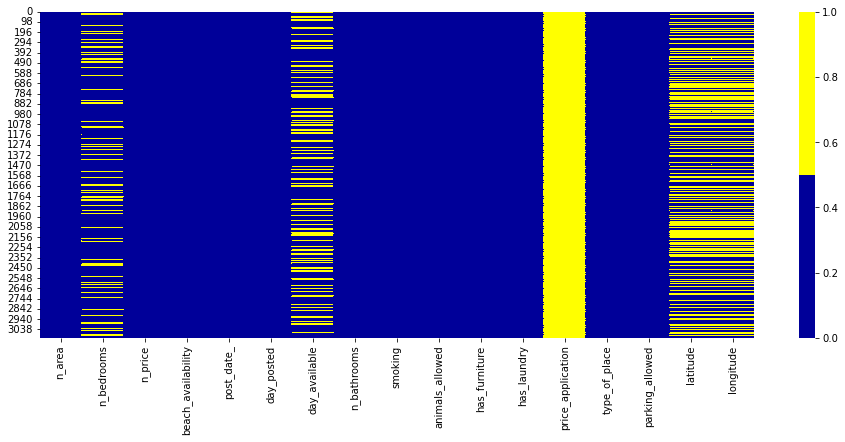

In [410]:
def plot_missing_values(df):
    import seaborn as sns
    cols = df.columns # first 30 columns
    plt.figure(figsize=(16, 6))
    colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
    return sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

plot_missing_values(df)

Lets drop columns with the highest amount of missing values: price_application. Given that 43% of values for these columns are missing, latitude and longtitude will be used just to plot the geographical location to visualize the data. These columns will not be used in a model.

In [411]:
# get the general overview of a dataset
df.describe()

,n_area,n_bedrooms,n_price,beach_availability,day_posted,day_available,n_bathrooms,smoking,latitude,longitude
count,3120.000000,2522.000000,3120.000000,3120.000000,3120.000000,2210.000000,3120.000000,3120.0,1770.000000,1770.000000
mean,572.030769,1.856463,1988.953205,0.341667,19.507692,17.000000,1.591667,1.0,21.248679,-157.746805
std,407.827424,0.800149,901.917606,0.474344,6.228208,9.365376,1.186893,0.0,0.322332,0.640797
min,1.000000,1.000000,515.000000,0.000000,2.000000,1.000000,1.000000,1.0,19.521285,-159.375234
25%,340.250000,1.000000,1395.000000,0.000000,16.000000,10.000000,1.000000,1.0,21.285980,-157.979472
50%,525.000000,2.000000,1787.500000,0.000000,23.000000,18.000000,1.000000,1.0,21.292762,-157.838001
75%,852.000000,2.000000,2500.000000,1.000000,23.000000,24.000000,2.000000,1.0,21.345300,-157.820367
max,2400.000000,4.000000,7200.000000,1.000000,30.000000,31.000000,5.000000,1.0,21.958448,-154.848988


Conclusions from a describe function:

1. An average (median) area of an apartment is 572 sqft, which is misleading cause some area values of 1 sqft. Should be assigned as NaN and imputed by the price or other missing values imputation methods. 
2. Apartments rental prices range from 7200 to 515 per month, with medium of 1788.
3. Max area does not exceed 2400 sqft, which may indicate that owners showed the area of apartments without adjacent territory, which may have been the case for areas more than 2400-2500 sqft.
4. Most place has 2 bedrooms and 2 bathrooms, with the cost of 2500 a month
5. 60 % of all places are apartments

In [412]:
def correct_n_area(df):
    # all apartments with area less than 70 sqft are converted to Nan values
    # df.loc[df['n_area'] < 70]['n_area'] = np.nan
    df['n_area'] = df['n_area'].apply(lambda x: np.nan if x < 50 else x)
    
    # Using the price variable, which corresponfss to an area, I will impute the missing area values
    #df['n_area'] = df.groupby('n_price').n_area.transform(lambda x: x.fillna(x.mean()))
    return df

df = correct_n_area(df)

In [413]:
df.head()

,n_area,n_bedrooms,n_price,beach_availability,post_date_,day_posted,day_available,n_bathrooms,smoking,animals_allowed,has_furniture,has_laundry,price_application,type_of_place,parking_allowed,latitude,longitude
0,800.0,NaN,1950,1,2021-07-16,16,NaN,1,1,No,No,No,NaN,No,No,NaN,NaN
1,480.0,1.0,1520,0,2021-07-19,19,19.0,1,1,No,No,No,NaN,Yes,Yes,21.287535,-157.820367
2,380.0,NaN,1500,1,2021-06-30,30,30.0,1,1,Yes,No,Yes,NaN,Yes,Yes,21.286107,-157.838986
3,400.0,1.0,1380,0,2021-07-24,24,NaN,1,1,No,No,No,NaN,No,Yes,NaN,NaN
4,650.0,1.0,1025,0,2021-07-24,24,24.0,1,1,Yes,No,No,NaN,Yes,Yes,NaN,NaN


In [414]:
df_geo = df.loc[:, "latitude":"longitude"]

In [415]:
df_posted = df.loc[:, 'post_date_']

In [416]:
df.head()

,n_area,n_bedrooms,n_price,beach_availability,post_date_,day_posted,day_available,n_bathrooms,smoking,animals_allowed,has_furniture,has_laundry,price_application,type_of_place,parking_allowed,latitude,longitude
0,800.0,NaN,1950,1,2021-07-16,16,NaN,1,1,No,No,No,NaN,No,No,NaN,NaN
1,480.0,1.0,1520,0,2021-07-19,19,19.0,1,1,No,No,No,NaN,Yes,Yes,21.287535,-157.820367
2,380.0,NaN,1500,1,2021-06-30,30,30.0,1,1,Yes,No,Yes,NaN,Yes,Yes,21.286107,-157.838986
3,400.0,1.0,1380,0,2021-07-24,24,NaN,1,1,No,No,No,NaN,No,Yes,NaN,NaN
4,650.0,1.0,1025,0,2021-07-24,24,24.0,1,1,Yes,No,No,NaN,Yes,Yes,NaN,NaN


In [417]:
type(df_posted)

pandas.core.series.Series

In [418]:
df = df[['n_area', 'n_bedrooms', 'beach_availability', 'day_posted',
       'day_available', 'n_bathrooms', 'smoking', 'animals_allowed',
       'has_furniture', 'has_laundry', 'type_of_place',
       'parking_allowed', 'latitude', 'longitude', 'post_date_', 'n_price']]

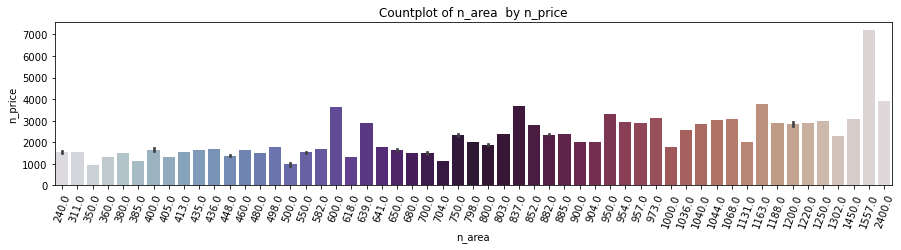

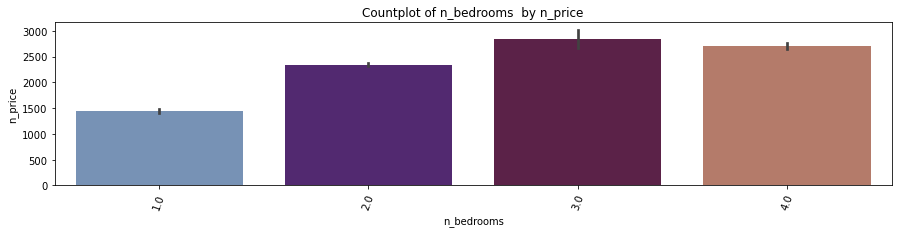

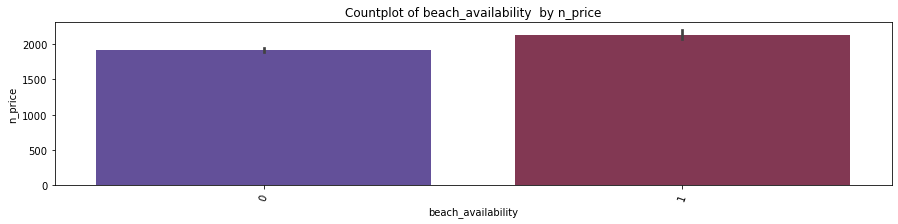

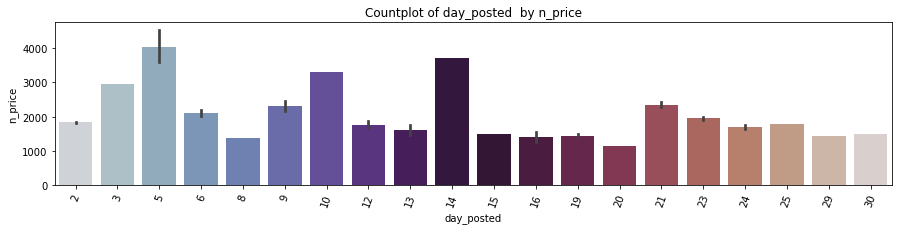

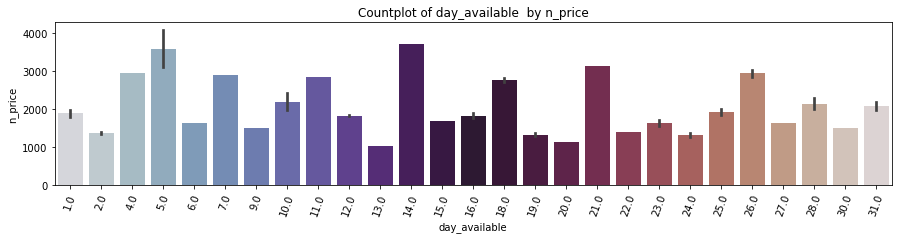

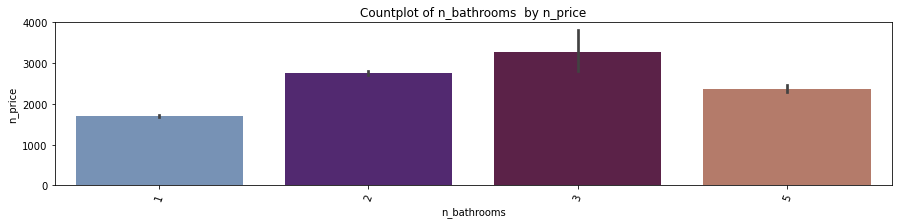

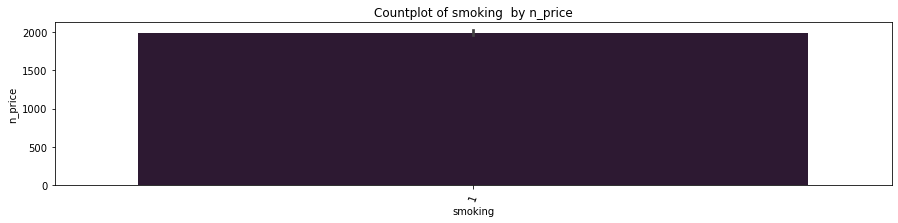

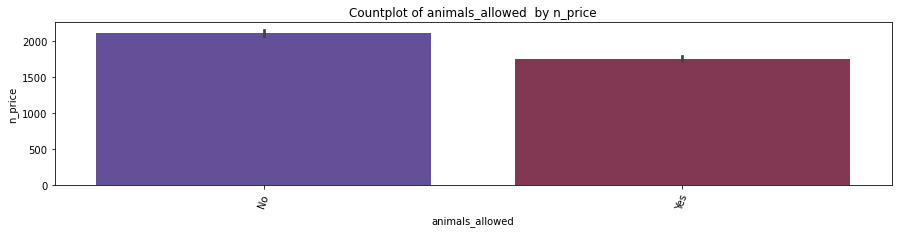

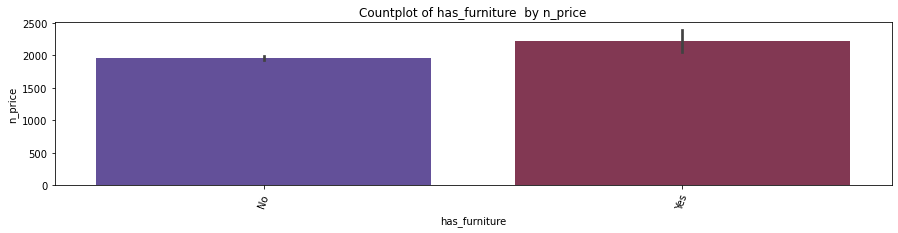

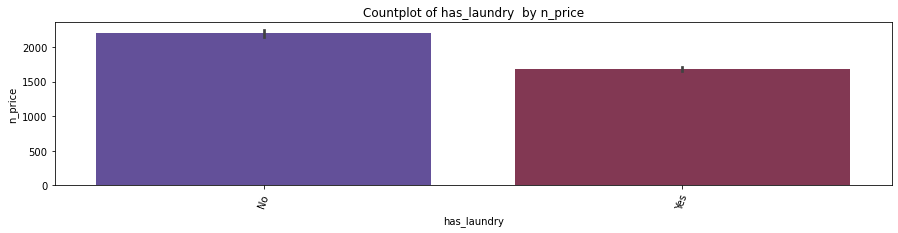

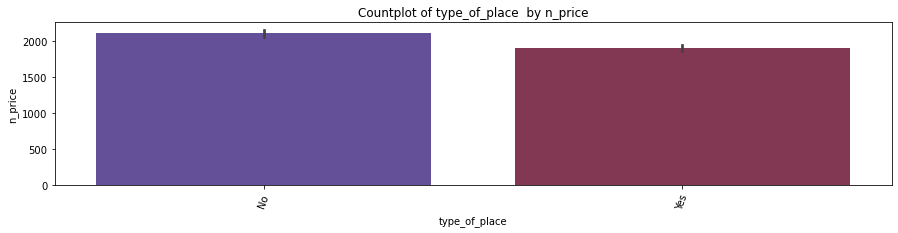

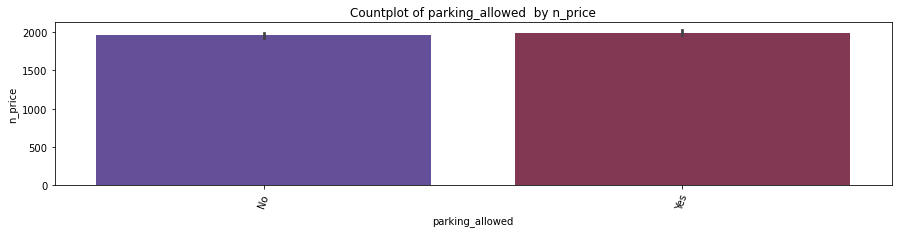

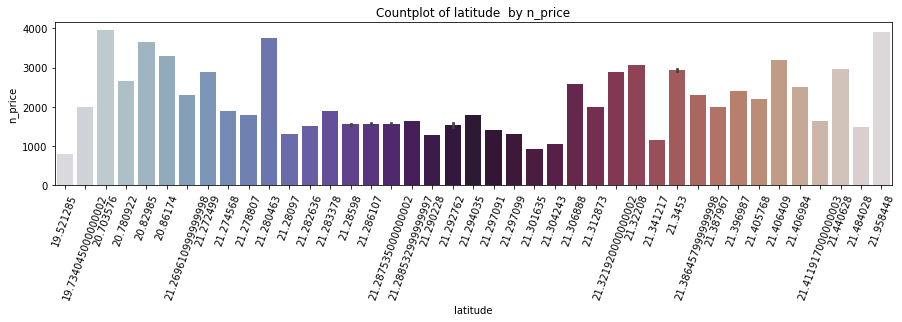

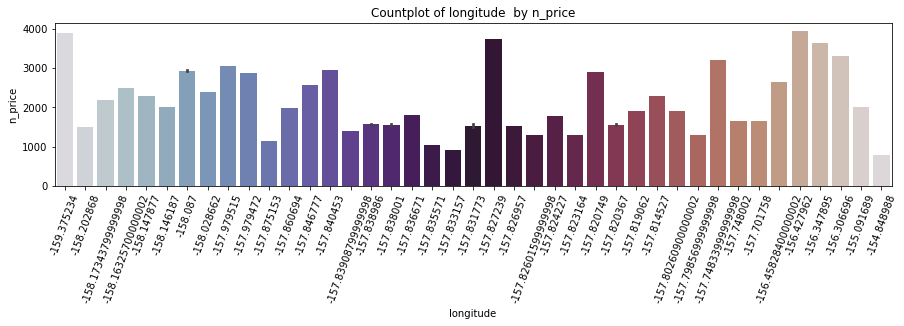

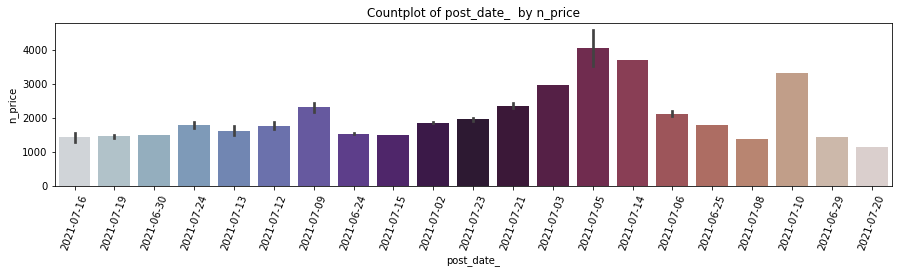

In [419]:
def count_plot(df):
    # plot potential predictors to visualize their countplot with respect to price
    for col in df.columns[:-1]:
        plt.figure(figsize=[15,3])
        sns.barplot(x=col,  y= df['n_price'], data=df, palette='twilight')
        plt.xticks(rotation=70)
        plt.title("Countplot of {}  by n_price".format(col))
        plt.show()
        
count_plot(df)

In [420]:
# nan values in area column
missing = round(df['n_area'].isna().sum()/df.shape[0]*100, 1)
print('missing values for n_area_column are', str(missing) + '%')


missing values for n_area_column are 18.3%


Summary of EDA analysis: how the independent features influence the dependent feature (n_price)


1. n_bathrooms: as number of bathrooms increases, the price increases as well peaking once number of bathrooms reaches.


2. n_bedrooms: similar trend is observed for number of bedrooms. These features should be correlated, therefore would be advantageous to create a new feature of number of room, which include bedrooms and bathrooms.


3. has_furniture: places with furniture have higher prices.


4. beach_availability: places closer to the beach have higher prices.


5. has_laundry: places with laundry have lower prices, which is intriguing and the reason is not so obvious


6. day_posted: landlords that posted their ads at the beginning of the month ask for more money than those who has been waiting for a while.


7. Even though there are 18.3 % of missing values for n_area column, there is still a correlation with the price. This feature is very important for the price prediction. Generally, as the area increases, the price increases as well


8. Other features do not seem to correlate with the rental price. So, they will be removed. Geolocation should be visualized to double check for the possible correlation.

In [421]:
def plot_Hawaii(df):
    """
    plots image accoring to the apartments coordinates found in Hawaii islands
    """
    import matplotlib.image as mpimg
    img=plt.imread(r'C:\Users\valer\Desktop\Projects\hawaii\haw.jpg')

    fig, ax = plt.subplots(figsize=(7,7), dpi = 300)
    ax.imshow(img, extent=[-160.00, -154.75, 19.42, 22.05])
    im = ax.scatter(x = df["longitude"], y=df["latitude"], c = df['n_price'], alpha=1, s = 20, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.0237, pad=0.04)
    cbar.set_label('n_price', fontsize=10)
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
    return plt.show()

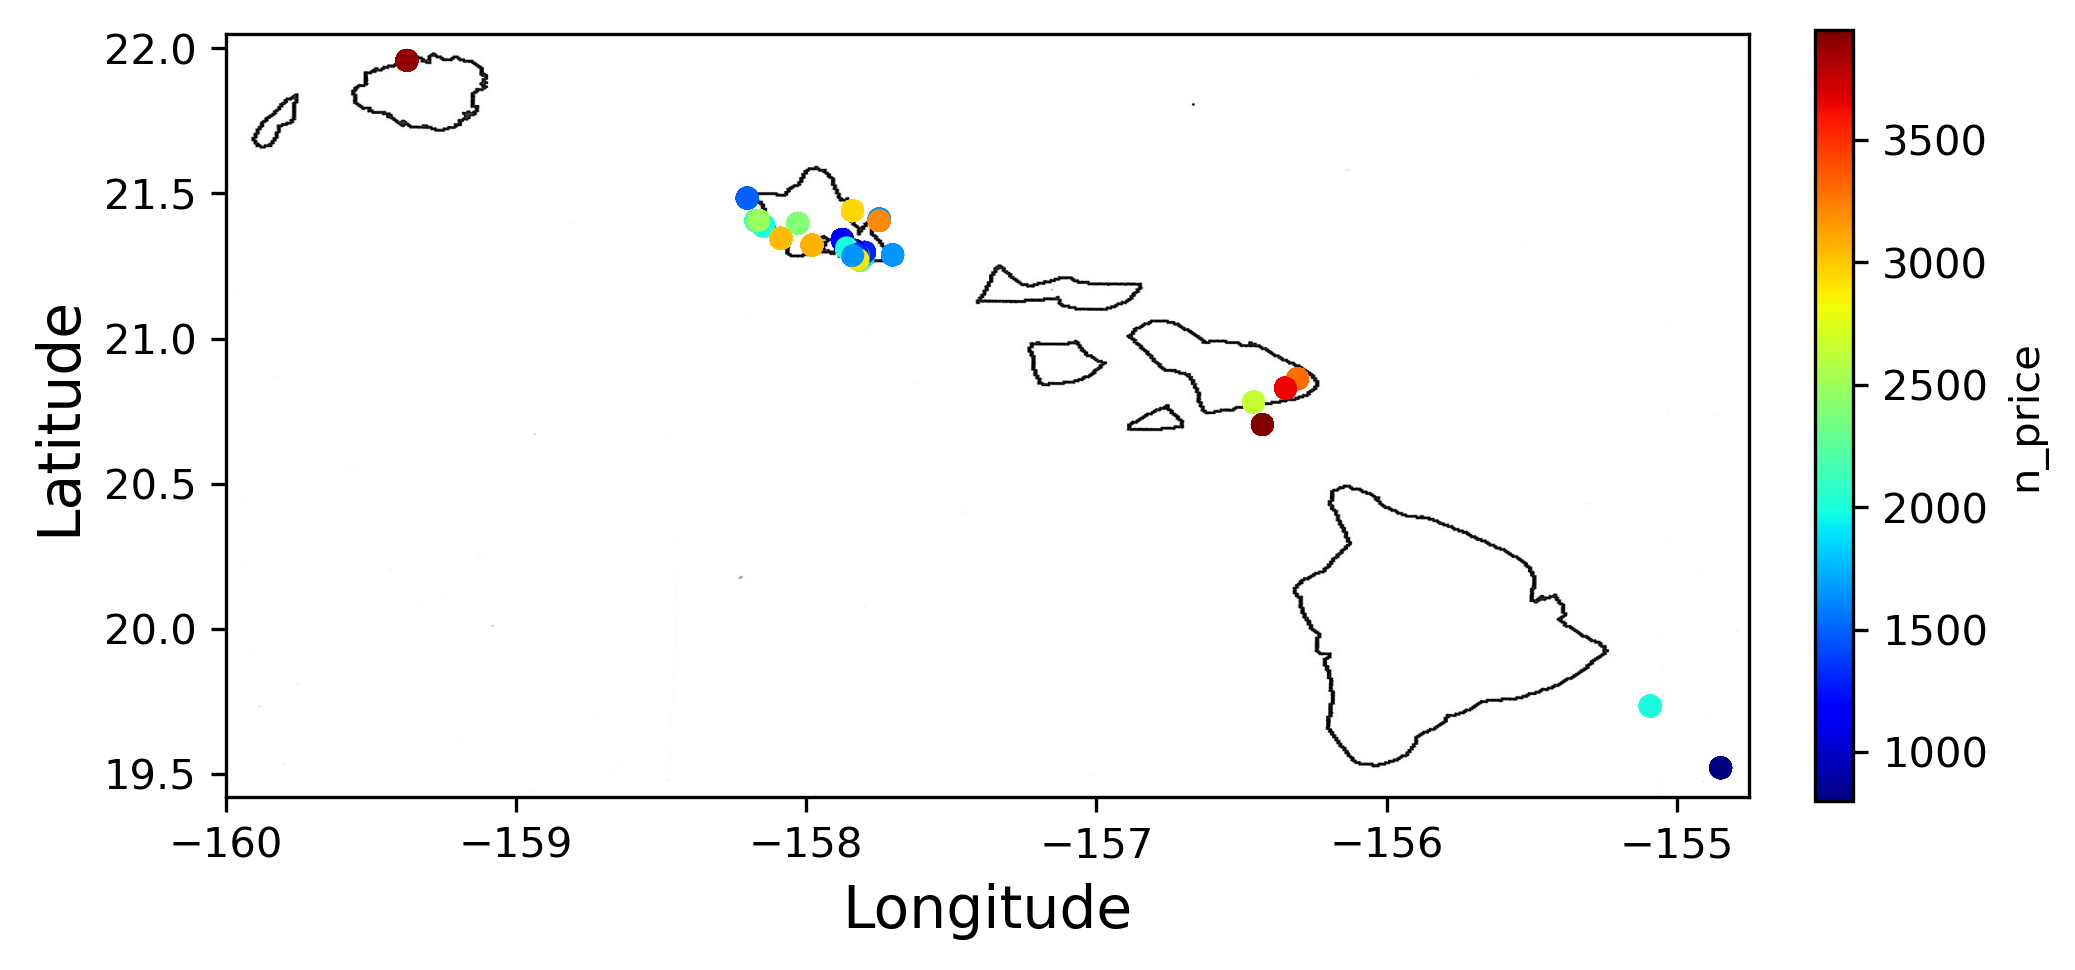

In [422]:
plot_Hawaii(df)

Lets have a closer look to the Oahu area

In [423]:
# get the Oahu coordinates
def oahu_coordinates(df):
    
    df_oahu = df[(df['longitude'] > -158.5) & (df['longitude'] < -157.5) 
             & (df['latitude'] > 21.00) & (df['latitude'] < 22.00)]
    return df_oahu

df_oahu = oahu_coordinates(df)

In [424]:
def plot_Oahu(df_oahu):
    """
    plots only Oahu island apartments 
    """
    fig, ax = plt.subplots(figsize=(4,4), dpi = 300)
    img_oahu=plt.imread(r'C:\Users\valer\Desktop\Projects\hawaii\oah.jpg')

    ax.imshow(img_oahu, extent=[-158.50, -157.5, 21.20, 21.95])
    im = ax.scatter(x = df_oahu["longitude"], y=df_oahu["latitude"], c = df_oahu['n_price'], alpha=1, s = 10, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('n_price', fontsize=10)
    cbar.ax.tick_params(labelsize=5)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.ylabel("Latitude", fontsize=5)
    plt.xlabel("Longitude", fontsize=5)
    return plt.show()

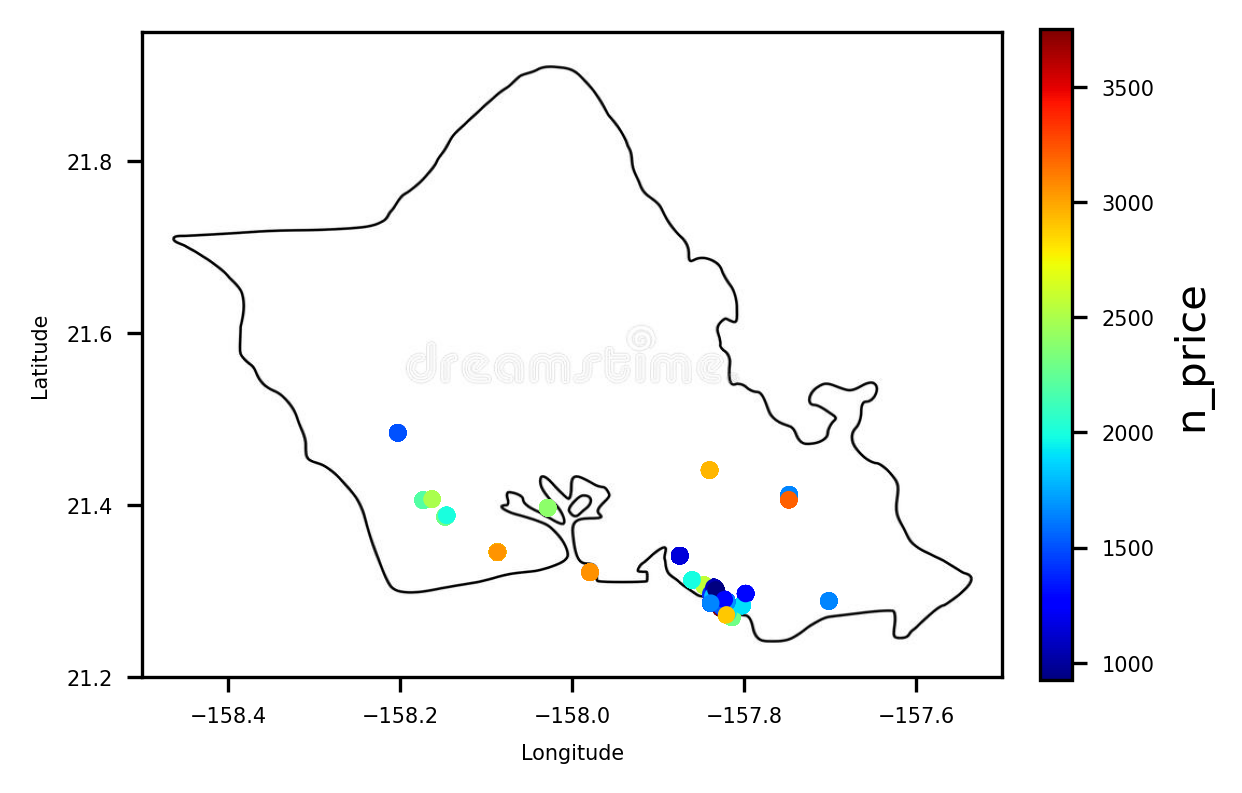

In [425]:
plot_Oahu(df_oahu)

Lets look at the Honolulu area

In [426]:
def Honolulu_coordinates(df):
    # get honolulu's coordinates
    df_hono = df[(df['longitude'] > -157.9) & (df['longitude'] < -157.75) & 
                 (df['latitude'] > 21.20) & (df['latitude'] < 21.37)]
    return df_hono

df_hono = Honolulu_coordinates(df)

In [427]:
def plot_Honolulu(df_hono):
    """
    plot Honolulu apartments
    """
    # upload Honolulu map
    fig, ax = plt.subplots(figsize=(4,4), dpi = 300)
    img_hono=plt.imread(r'C:\Users\valer\Desktop\Projects\hawaii\cc.jpg')
    ax.imshow(img_hono, extent=[-157.88, -157.670, 21.233, 21.37])
    
    # map a scatter plot onto the Honolulu template
    im = ax.scatter(x = df_hono["longitude"], y=df_hono["latitude"], 
                    c = df_hono['n_price'], alpha=1, s = 5, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('n_price', fontsize=5)
    cbar.ax.tick_params(labelsize=5)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.ylabel("Latitude", fontsize=5)
    plt.xlabel("Longitude", fontsize=5)
    
    return plt.show()

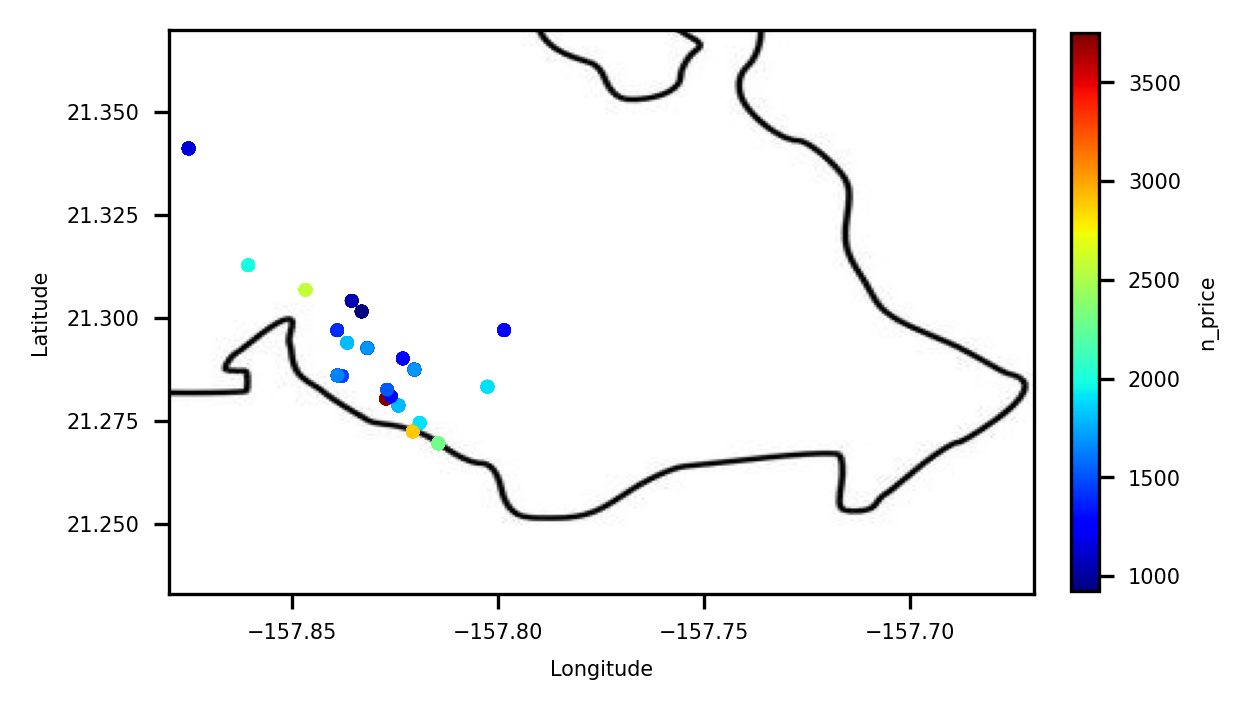

In [428]:
plot_Honolulu(df_hono)

Influence of coordinates on apartments prices:

    It looks like places closer to the shore line have higher prices comparing with places located further away from the beach. The major issue is that the number of houses with the available coordinates is very small comparing to the number of records in the dataset, meaning that we can not rely on the whatever correlation we might detect from the geo location data. Longitude and latitude have the highest percent of the missing values, and they are unique values corresponding to the geolocation of the apartments. Given that we already have beach availability feature in the dataset, we should be worried about the dropping two columns from a dataset as they do not even correlate with the target feature.

# Feature engineering
0. Train_test split
1. Missng values imputation
2. Creating new features
3. Scaling
4. Discretization
5. Encoding categorical features
6. Feature Crossing


Test train split. To avoid the data leakage during the imputation of the missing values, lets perform the test train split and inpute values only at the train split for now

In [429]:
df.columns

Index(['n_area', 'n_bedrooms', 'beach_availability', 'day_posted',
       'day_available', 'n_bathrooms', 'smoking', 'animals_allowed',
       'has_furniture', 'has_laundry', 'type_of_place', 'parking_allowed',
       'latitude', 'longitude', 'post_date_', 'n_price'],
      dtype='object')

In [430]:
#To select features I need to split the dataset to independent and dependent variables
X = df.drop('n_price', axis =1)
Y = df['n_price']

#train_tets_split to ensure no data would leak to test data  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Missng values imputation

Missing values might be classified in three different ways:

1. MNAR - missing not at random
2. MAR - missing at random
2. MCAR - missing compeletely at random


lets concentrate on the features selected during the EDA analysis

In [431]:
df_train = X_train[['n_area', 'n_bedrooms', 'beach_availability', 'day_posted',
    'n_bathrooms', 'animals_allowed',
       'has_furniture', 'has_laundry']]


df_test = X_test[['n_area', 'n_bedrooms', 'beach_availability', 'day_posted',
    'n_bathrooms', 'animals_allowed',
       'has_furniture', 'has_laundry']]

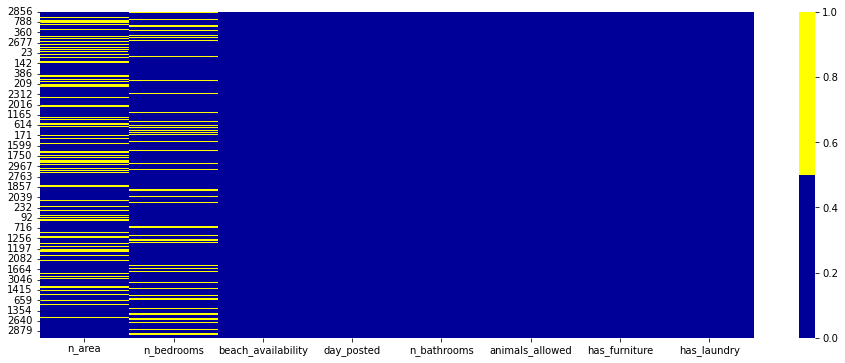

In [432]:
def plot_missing_values(df_train):
    import seaborn as sns
    cols = df_train.columns # first 30 columns
    plt.figure(figsize=(16, 6))
    colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
    return sns.heatmap(df_train[cols].isnull(), cmap=sns.color_palette(colours))

plot_missing_values(df_train)

There are various method for the missing values imputation. Here I will try the most commonly used ones:
1. Dropping columns of missing values.
2. Imputation of missing values by their mean.
3. Imputation of missing values by their mode (especially useful for categorical features).
4. Imputation of missing values by their median.
5. Imputation of missing values by random selection.
6. Imputation of missing values by regression model.
6. Imputation of missing values by KNN.
6. Imputation of missing values by outliers.
6. Imputation of missing values by other feature.

Lets impute the number of bedrooms feature by the abovementioned methods

In [433]:
df_train.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry
2856,1200.0,4.0,0,23,5,No,No,No
3104,798.0,1.0,0,23,1,No,No,No
1611,498.0,NaN,1,25,1,Yes,No,Yes
440,885.0,2.0,0,23,5,Yes,No,No
508,1557.0,3.0,1,5,3,No,Yes,No


In [434]:
df_test.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry
2898,385.0,NaN,0,19,1,Yes,No,Yes
2976,1200.0,4.0,0,23,5,No,No,No
2130,1200.0,3.0,1,23,2,No,No,No
214,405.0,NaN,1,23,1,No,Yes,Yes
1068,700.0,1.0,0,23,1,No,No,Yes


In [435]:


# looks like n_bathrooms and n_bedrooms have something in common, so lets use one to inpute another one
column_to_impute = 'n_bedrooms'
axiliary_column = 'n_bathrooms'


#dropping columns
def drop_nan(df, variable):
    df[variable+'_dropped'] = df[variable].fillna(0)
    return df


# mean imputation
def impute_nan_mean(df, variable):
    mean = df[variable].mean()
    df[variable+'_mean'] = df[variable].fillna(mean)
    return df


# mode imputation
def impute_nan_mode(df, variable):
    mode = df[variable].mode()
    df[variable+'_mode'] = df[variable].fillna(mode[0])
    return df

# median imputation
def impute_nan_median(df, variable):
    median = df[variable].median()
    df[variable+'_median'] = df[variable].fillna(median)
    return df

# Random sample imputation peaks random data to replace the nan values applied for MCAR
def impute_nan_random(df,variable):
    median = df[variable].median()
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample
    variable = df[variable]
    return df

# regression_imputer
def Regression(df, variable):
    reg_imputer = IterativeImputer(max_iter=10, random_state=123)
    vals = df[variable].values.reshape(-1,1)
    reg_imputer.fit(vals)
    df[variable + '_regression'] = reg_imputer.transform(vals)
    return df

# KNN imputation
def impute_KNN(df, variable):
    knn_imputer = KNNImputer(n_neighbors=3)
    inputt = df[variable].values.reshape(-1,1)
    res = knn_imputer.fit_transform(inputt).round()
    df[variable + '_KNN'] = res 
    return df

# by outliers
def impute_by_outliers(df, variable):
    extreme = df[variable].mean() + 3*df[variable].std()
    df[variable + '_extreme'] = df[variable].fillna(extreme)
    return df

# group by Price. Trying to predict the missing n_bedrooms by the grouping known n_bedrooms by apartment price, and 
# filling unknown n_bedrooms values that corresponds to the n_price variable
def impute_by_Price(df, variable, axiliary_column):
    df[variable + '_by_' + axiliary_column] = df[variable].fillna(df.groupby(axiliary_column)[variable].transform('median'))
    return df



def main_imputation(df, column_to_impute, axiliary_column):
    
    df = drop_nan(df, column_to_impute)
    df = impute_nan_mean(df, column_to_impute)
    df = impute_nan_mode(df, column_to_impute)
    df = impute_nan_median(df, column_to_impute)
    df = impute_nan_random(df,column_to_impute)
    df = impute_by_Price(df, column_to_impute, axiliary_column)
    df = Regression(df, column_to_impute)
    df = impute_KNN(df, column_to_impute)
    df = impute_by_outliers(df, column_to_impute)
    
    return df

In [436]:
df_train = main_imputation(df_train,'n_bedrooms', 'n_bathrooms')
df_test = main_imputation(df_test,'n_bedrooms', 'n_bathrooms')

In [437]:
df_train.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry,n_bedrooms_dropped,n_bedrooms_mean,n_bedrooms_mode,n_bedrooms_median,n_bedrooms_random,n_bedrooms_by_n_bathrooms,n_bedrooms_regression,n_bedrooms_KNN,n_bedrooms_extreme
2856,1200.0,4.0,0,23,5,No,No,No,4.0,4.000000,4.0,4.0,4.0,4.0,4.000000,4.0,4.000000
3104,798.0,1.0,0,23,1,No,No,No,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000
1611,498.0,NaN,1,25,1,Yes,No,Yes,0.0,1.871429,2.0,2.0,2.0,1.0,1.871429,2.0,4.304335
440,885.0,2.0,0,23,5,Yes,No,No,2.0,2.000000,2.0,2.0,2.0,2.0,2.000000,2.0,2.000000
508,1557.0,3.0,1,5,3,No,Yes,No,3.0,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000


In [438]:
df_test.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry,n_bedrooms_dropped,n_bedrooms_mean,n_bedrooms_mode,n_bedrooms_median,n_bedrooms_random,n_bedrooms_by_n_bathrooms,n_bedrooms_regression,n_bedrooms_KNN,n_bedrooms_extreme
2898,385.0,NaN,0,19,1,Yes,No,Yes,0.0,1.826603,2.0,2.0,1.0,1.0,1.826603,2.0,4.159778
2976,1200.0,4.0,0,23,5,No,No,No,4.0,4.000000,4.0,4.0,4.0,4.0,4.000000,4.0,4.000000
2130,1200.0,3.0,1,23,2,No,No,No,3.0,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000
214,405.0,NaN,1,23,1,No,Yes,Yes,0.0,1.826603,2.0,2.0,1.0,1.0,1.826603,2.0,4.159778
1068,700.0,1.0,0,23,1,No,No,Yes,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000


In [439]:
df_train.shape

(2090, 17)

In [440]:
df_test.shape

(1030, 17)

In [441]:
def plot_imputed_bedrooms(df):
    """
    this plots the orifinal distribution of the area variable and the distributions 
    obtained after the imputations of the missing values. The goal is to find imputation that is
    closely correlated to the otiginal distribution (grey color)
    """
    
    columns_to_plot = ['n_bedrooms', 'n_bedrooms_dropped',
       'n_bedrooms_mean', 'n_bedrooms_mode', 'n_bedrooms_median',
       'n_bedrooms_random', 'n_bedrooms_by_n_bathrooms',
       'n_bedrooms_regression', 'n_bedrooms_KNN', 'n_bedrooms_extreme']
    
    colors = ['red', 'yellow', 'magenta', 'black', 'orange', 'cyan', 'green', 'grey', 'blue', 'black']
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    i = 0
    for col in columns_to_plot:
        
        if col == 'n_bedrooms':
            
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=20, alpha=0.6)
            i += 1
        
        else:
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=10, alpha=0.3)
            i += 1


        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
        plt.legend(fontsize=20) # using a size in points
        plt.legend(fontsize="xx-large") # using a named size

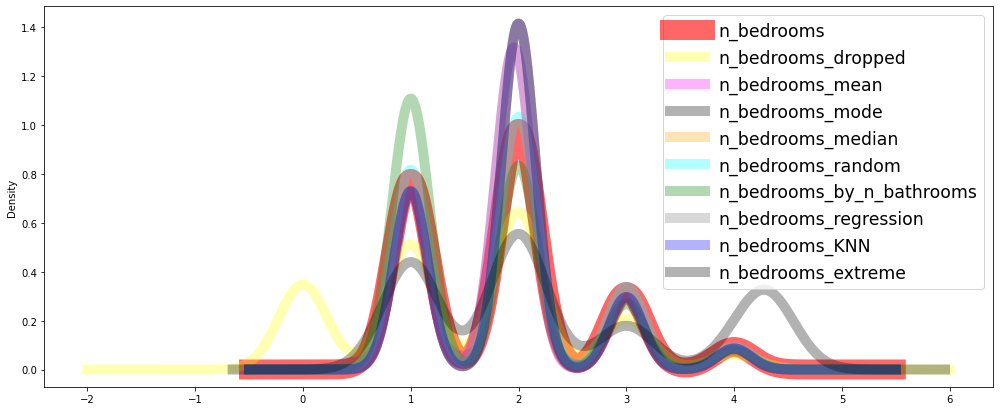

In [442]:
plot_imputed_bedrooms(df_train)

Choosing the best function to impute values.....

In [443]:
def plot_imputed_bedrooms(df):

    
    columns_to_plot = ['n_bedrooms', 'n_bedrooms_mode',
       'n_bedrooms_random', 'n_bedrooms_KNN']
    
    colors = ['red', 'yellow', 'magenta', 'black']
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    i = 0
    for col in columns_to_plot:
        
        if col == 'n_bedrooms':
            
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=30, alpha=0.2)
            i += 1
        
        else:
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=10, alpha=0.3)
            i += 1


        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
        plt.legend(fontsize=20) # using a size in points
        plt.legend(fontsize="xx-large") # using a named size

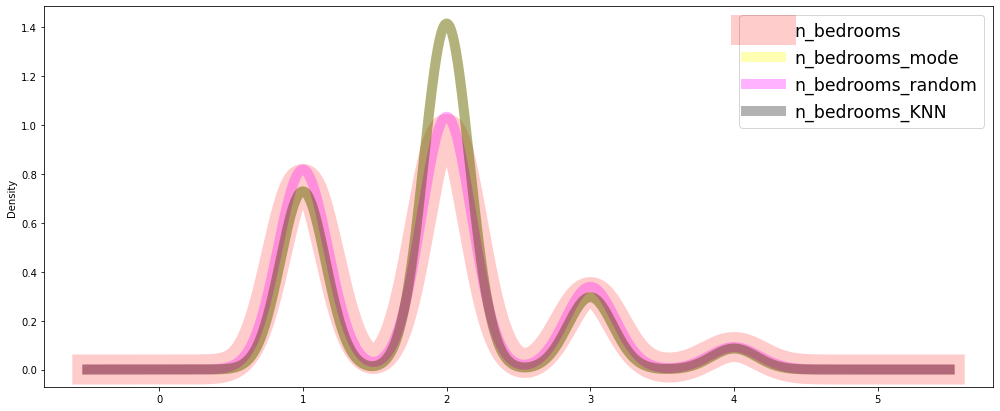

In [444]:
plot_imputed_bedrooms(df_train)

In [445]:
def plot_imputed_bedrooms(df):

    
    columns_to_plot = ['n_bedrooms', 'n_bedrooms_mode']
    
    colors = ['red', 'yellow']
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    i = 0
    for col in columns_to_plot:
        
        if col == 'n_bedrooms':
            
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=30, alpha=0.2)
            i += 1
        
        else:
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=10, alpha=0.3)
            i += 1


        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
        plt.legend(fontsize=20) # using a size in points
        plt.legend(fontsize="xx-large") # using a named size

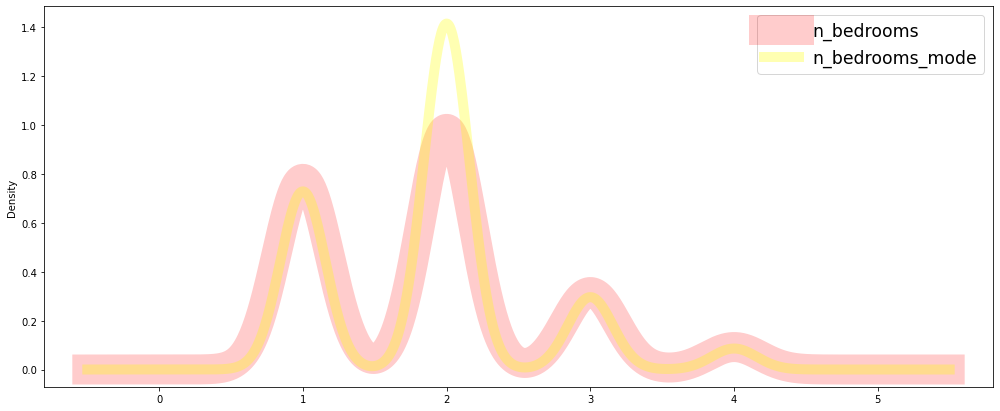

In [446]:
plot_imputed_bedrooms(df_train)

finally, the best results for missing values imputation was achieved using random imputer, I however would choose the values imputed by mode method as it provides more understanding in the process

Lets impute the area column and create auxilary column of total room number, so we used the new feature for the imputation

In [447]:
df_train['n_room_total'] = df_train['n_bathrooms'] + df_train['n_bedrooms_mode']
df_test['n_room_total'] = df_test['n_bathrooms'] + df_test['n_bedrooms_mode']

In [448]:
def main_imputation(df, column_to_impute, axiliary_column):
    
    df = drop_nan(df, column_to_impute)
    df = impute_nan_mean(df, column_to_impute)
    df = impute_nan_mode(df, column_to_impute)
    df = impute_nan_median(df, column_to_impute)
    df = impute_nan_random(df,column_to_impute)
    df = impute_by_Price(df, column_to_impute, axiliary_column)
    df = Regression(df, column_to_impute)
    df = impute_KNN(df, column_to_impute)
    df = impute_by_outliers(df, column_to_impute)
    
    return df

In [449]:
df_train = main_imputation(df_train, 'n_area', 'n_room_total')
df_test = main_imputation(df_test, 'n_area', 'n_room_total')

In [450]:
df_train.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry,n_bedrooms_dropped,n_bedrooms_mean,n_bedrooms_mode,n_bedrooms_median,n_bedrooms_random,n_bedrooms_by_n_bathrooms,n_bedrooms_regression,n_bedrooms_KNN,n_bedrooms_extreme,n_room_total,n_area_dropped,n_area_mean,n_area_mode,n_area_median,n_area_random,n_area_by_n_room_total,n_area_regression,n_area_KNN,n_area_extreme
2856,1200.0,4.0,0,23,5,No,No,No,4.0,4.000000,4.0,4.0,4.0,4.0,4.000000,4.0,4.000000,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
3104,798.0,1.0,0,23,1,No,No,No,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,2.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0
1611,498.0,NaN,1,25,1,Yes,No,Yes,0.0,1.871429,2.0,2.0,2.0,1.0,1.871429,2.0,4.304335,3.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0
440,885.0,2.0,0,23,5,Yes,No,No,2.0,2.000000,2.0,2.0,2.0,2.0,2.000000,2.0,2.000000,7.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0
508,1557.0,3.0,1,5,3,No,Yes,No,3.0,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,6.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0


In [451]:
df_test.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry,n_bedrooms_dropped,n_bedrooms_mean,n_bedrooms_mode,n_bedrooms_median,n_bedrooms_random,n_bedrooms_by_n_bathrooms,n_bedrooms_regression,n_bedrooms_KNN,n_bedrooms_extreme,n_room_total,n_area_dropped,n_area_mean,n_area_mode,n_area_median,n_area_random,n_area_by_n_room_total,n_area_regression,n_area_KNN,n_area_extreme
2898,385.0,NaN,0,19,1,Yes,No,Yes,0.0,1.826603,2.0,2.0,1.0,1.0,1.826603,2.0,4.159778,3.0,385.0,385.0,385.0,385.0,385.0,385.0,385.0,385.0,385.0
2976,1200.0,4.0,0,23,5,No,No,No,4.0,4.000000,4.0,4.0,4.0,4.0,4.000000,4.0,4.000000,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
2130,1200.0,3.0,1,23,2,No,No,No,3.0,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
214,405.0,NaN,1,23,1,No,Yes,Yes,0.0,1.826603,2.0,2.0,1.0,1.0,1.826603,2.0,4.159778,3.0,405.0,405.0,405.0,405.0,405.0,405.0,405.0,405.0,405.0
1068,700.0,1.0,0,23,1,No,No,Yes,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,2.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0


In [452]:
def plot_imputed_bedrooms(df):
    """
    this plots the orifinal distribution of the area variable and the distributions 
    obtained after the imputations of the missing values. The goal is to find imputation that is
    closely correlated to the otiginal distribution (grey color)
    """
    
    columns_to_plot = ['n_area', 'n_area_dropped', 'n_area_mean', 'n_area_mode',
       'n_area_median', 'n_area_random', 'n_area_by_n_room_total',
       'n_area_regression', 'n_area_KNN', 'n_area_extreme']
    
    colors = ['red', 'yellow', 'magenta', 'black', 'orange', 'cyan', 'green', 'grey', 'blue', 'black']
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    i = 0
    for col in columns_to_plot:
        
        if col == 'n_area':
            
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=20, alpha=0.6)
            i += 1
        
        else:
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=10, alpha=0.3)
            i += 1


        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
        plt.legend(fontsize=20) # using a size in points
        plt.legend(fontsize="xx-large") # using a named size

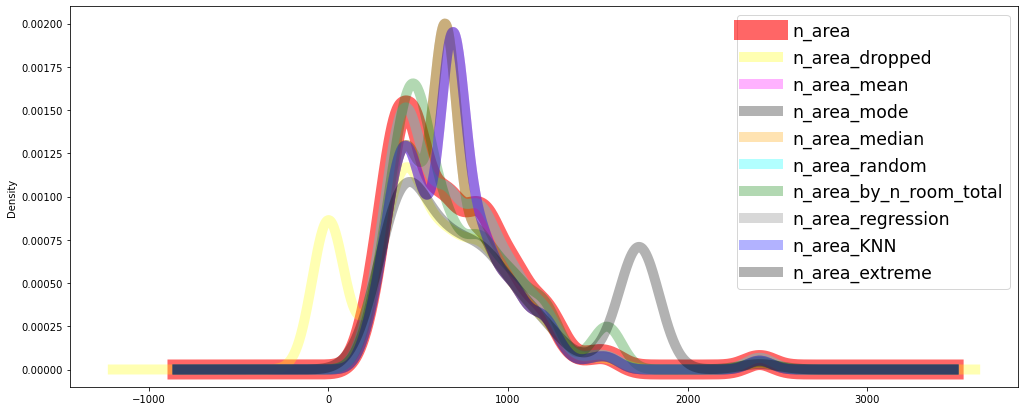

In [453]:
plot_imputed_bedrooms(df_train)

In [454]:
def plot_imputed_bedrooms(df):
    """
    this plots the orifinal distribution of the area variable and the distributions 
    obtained after the imputations of the missing values. The goal is to find imputation that is
    closely correlated to the otiginal distribution (grey color)
    """
    
    columns_to_plot = ['n_area', 'n_area_random', 'n_area_by_n_room_total']
    
    colors = ['red', 'yellow', 'magenta']
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    i = 0
    for col in columns_to_plot:
        
        if col == 'n_area':
            
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=20, alpha=0.6)
            i += 1
        
        else:
            df[col].plot(kind='kde', ax=ax, color = colors[i],  linewidth=10, alpha=0.3)
            i += 1


        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
        plt.legend(fontsize=20) # using a size in points
        plt.legend(fontsize="xx-large") # using a named size

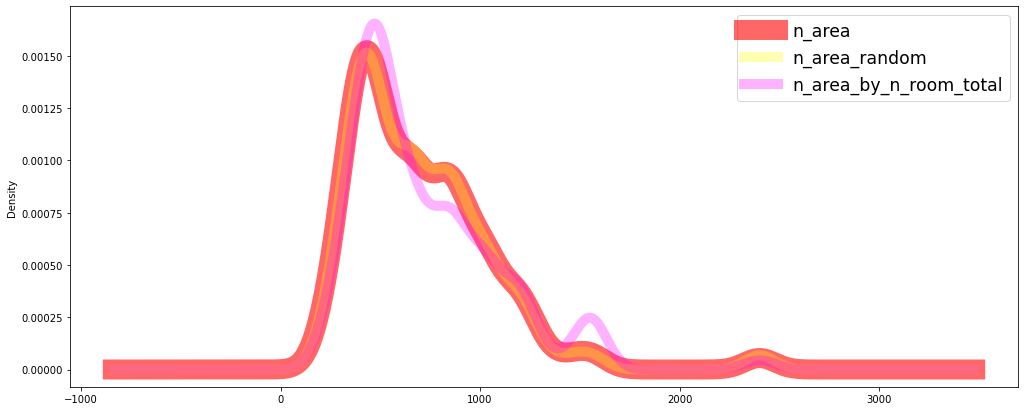

In [455]:
plot_imputed_bedrooms(df_train)

Even tough the random imputer showed better distribution after missing values imputation, I would choose the n_area_imputed by the number of room as it gives much more sense and reliability.

In [456]:
df_train['n_area_by_n_room_total'].isna().sum()

56

There is still 56 missing values out of 3120, which accounts for...


In [457]:
df_train['n_area_by_n_room_total'].isna().sum()/df_train.shape[0]

0.026794258373205742

2.6 per cent, I would inpute them using random imputer to avoid data loss

In [458]:
# Random sample imputation peaks random data to replace the nan values applied for MCAR
def impute_nan_random(df,variable):
    median = df[variable].median()
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample
    variable = df[variable]
    return df


df_train = impute_nan_random(df_train,'n_area_by_n_room_total')
df_test = impute_nan_random(df_test,'n_area_by_n_room_total')

In [459]:
df_train['n_area_by_n_room_total_random'].isna().sum()

0

In [460]:
df_train.head()

,n_area,n_bedrooms,beach_availability,day_posted,n_bathrooms,animals_allowed,has_furniture,has_laundry,n_bedrooms_dropped,n_bedrooms_mean,n_bedrooms_mode,n_bedrooms_median,n_bedrooms_random,n_bedrooms_by_n_bathrooms,n_bedrooms_regression,n_bedrooms_KNN,n_bedrooms_extreme,n_room_total,n_area_dropped,n_area_mean,n_area_mode,n_area_median,n_area_random,n_area_by_n_room_total,n_area_regression,n_area_KNN,n_area_extreme,n_area_by_n_room_total_median,n_area_by_n_room_total_random
2856,1200.0,4.0,0,23,5,No,No,No,4.0,4.000000,4.0,4.0,4.0,4.0,4.000000,4.0,4.000000,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
3104,798.0,1.0,0,23,1,No,No,No,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,2.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0,798.0
1611,498.0,NaN,1,25,1,Yes,No,Yes,0.0,1.871429,2.0,2.0,2.0,1.0,1.871429,2.0,4.304335,3.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0,498.0
440,885.0,2.0,0,23,5,Yes,No,No,2.0,2.000000,2.0,2.0,2.0,2.0,2.000000,2.0,2.000000,7.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0,885.0
508,1557.0,3.0,1,5,3,No,Yes,No,3.0,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,6.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0,1557.0


Lets select features for future preprocessing

Some predictors showed the lower correlaton coefficient, this however do not mean that we should exclude them from our consideration. There are methods that allow nonlinear feature selection and might shed light onto the hidden and nonlinear dependencies between the n_price and predictors.

In [461]:
df_train = df_train[['n_area_by_n_room_total_random', 'beach_availability', 'n_bedrooms_mode', 'n_bathrooms',
          'day_posted', 'animals_allowed', 'has_furniture']]


df_test = df_test[['n_area_by_n_room_total_random', 'beach_availability', 'n_bedrooms_mode', 'n_bathrooms',
          'day_posted', 'animals_allowed', 'has_furniture']]

In [462]:
df_train.head()

,n_area_by_n_room_total_random,beach_availability,n_bedrooms_mode,n_bathrooms,day_posted,animals_allowed,has_furniture
2856,1200.0,0,4.0,5,23,No,No
3104,798.0,0,1.0,1,23,No,No
1611,498.0,1,2.0,1,25,Yes,No
440,885.0,0,2.0,5,23,Yes,No
508,1557.0,1,3.0,3,5,No,Yes


In [463]:
df_test.head()

,n_area_by_n_room_total_random,beach_availability,n_bedrooms_mode,n_bathrooms,day_posted,animals_allowed,has_furniture
2898,385.0,0,2.0,1,19,Yes,No
2976,1200.0,0,4.0,5,23,No,No
2130,1200.0,1,3.0,2,23,No,No
214,405.0,1,2.0,1,23,No,Yes
1068,700.0,0,1.0,1,23,No,No


In [464]:
df_train.isna().sum()

n_area_by_n_room_total_random    0
beach_availability               0
n_bedrooms_mode                  0
n_bathrooms                      0
day_posted                       0
animals_allowed                  0
has_furniture                    0
dtype: int64

In [465]:
def convertion_yes_no_values(df):
    # convert yes/no to int 1 or 0
    columns_to_convert = ['animals_allowed', 'has_furniture']
    for col in columns_to_convert:
        df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)
    return df

In [466]:
df_train = convertion_yes_no_values(df_train)
df_test = convertion_yes_no_values(df_test)
df_train.head()

,n_area_by_n_room_total_random,beach_availability,n_bedrooms_mode,n_bathrooms,day_posted,animals_allowed,has_furniture
2856,1200.0,0,4.0,5,23,0,0
3104,798.0,0,1.0,1,23,0,0
1611,498.0,1,2.0,1,25,1,0
440,885.0,0,2.0,5,23,1,0
508,1557.0,1,3.0,3,5,0,1


# Creating new features

In [467]:
df_train.head()

,n_area_by_n_room_total_random,beach_availability,n_bedrooms_mode,n_bathrooms,day_posted,animals_allowed,has_furniture
2856,1200.0,0,4.0,5,23,0,0
3104,798.0,0,1.0,1,23,0,0
1611,498.0,1,2.0,1,25,1,0
440,885.0,0,2.0,5,23,1,0
508,1557.0,1,3.0,3,5,0,1


In [468]:
df_train.columns

Index(['n_area_by_n_room_total_random', 'beach_availability',
       'n_bedrooms_mode', 'n_bathrooms', 'day_posted', 'animals_allowed',
       'has_furniture'],
      dtype='object')

In [469]:
df_train.columns = ['n_area', 'beach', 'n_bedrooms', 'n_bathrooms', 'day_posted',
       'animals', 'furniture']

df_test.columns = ['n_area', 'beach', 'n_bedrooms', 'n_bathrooms', 'day_posted',
       'animals', 'furniture']

As bedrooms and bathroom are type os a room, thus lets marge them together by two ways: summation and multiplication

In [470]:
def new_feaures_1(df):
    
    # rooms added
    df['rooms+'] = df['n_bedrooms'] + df['n_bathrooms']

    # rooms multiplied
    df['rooms*'] = df['n_bedrooms'] * df['n_bathrooms']

    # bedrooms_to_bathrooms ratio
    df['bedrooms_to_bathrooms'] = df['n_bedrooms']/df['n_bathrooms']
    
    # rooms with and without furniture
    df['furnitured_room'] = df['n_bedrooms'] + df['n_bedrooms'] * df['furniture']
    
    """
    take the diff between posted and the todays date
    data got scraped on the 24th of July
    """
    df['day_diff'] = df['day_posted'].apply(lambda x: (24 - x) if x <=24 else (24 + 30 - x))

    return df

In [471]:
df_train = new_feaures_1(df_train)
df_test = new_feaures_1(df_test)

In [472]:
def new_feaures_2(df):
    
    # how much sqft in each total rooms
    df['room_area+'] = df['n_area']/df['rooms+']
    df['room_area*'] = df['n_area']/df['rooms*']
    return df

In [473]:
df_train = new_feaures_2(df_train)
df_test = new_feaures_2(df_test)

Discretization

for better predictions it is feasible to cluster the area to small, middle, large, and massive area chunks based on the quantile division

In [474]:
def quantile_division(df_train):
    
    quantiles = [0.25, 0.5, 0.75, 1]
    
    for quan in quantiles:
        area = df_train['n_area'].quantile(quan)
        print(f'for qunatile {quan} the area is {area}')
    

In [475]:
quantile_division(df_train)

for qunatile 0.25 the area is 480.0
for qunatile 0.5 the area is 641.0
for qunatile 0.75 the area is 904.0
for qunatile 1 the area is 2400.0


In [476]:
def area_clustering(x):

    if x <= 480.0:
        return 'small'
    elif x<= 641.0:
        return 'medium'
    elif x <= 904.0:
        return 'large'
    else:
        return 'massive'


def area_mapping(x):
    
    area_mapping = {
        'small' : 1,
        'medium' : 2,
        'large': 3,
        'massive': 4
    }
    return area_mapping[x]

In [477]:
df_train['area_cluster'] =df_train['n_area'].apply(lambda x: area_clustering(x))
df_train['area_cluster'] = df_train['area_cluster'].apply(lambda x: area_mapping(x))


df_test['area_cluster'] =df_test['n_area'].apply(lambda x: area_clustering(x))
df_test['area_cluster'] = df_test['area_cluster'].apply(lambda x: area_mapping(x))

In [478]:
df_train.shape

(2090, 15)

In [479]:
df_train = pd.concat([df_train, y_train], axis = 1)
df_test = pd.concat([df_test, y_test], axis = 1)

In [480]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(3120, 16)

In [481]:
df.columns

Index(['n_area', 'beach', 'n_bedrooms', 'n_bathrooms', 'day_posted', 'animals',
       'furniture', 'rooms+', 'rooms*', 'bedrooms_to_bathrooms',
       'furnitured_room', 'day_diff', 'room_area+', 'room_area*',
       'area_cluster', 'n_price'],
      dtype='object')

In [482]:
df.shape

(3120, 16)

In [483]:
df_geo.shape

(3120, 2)

In [484]:
df_posted.shape

(3120,)

In [485]:
df_geo.head()

,latitude,longitude
0,NaN,NaN
1,21.287535,-157.820367
2,21.286107,-157.838986
3,NaN,NaN
4,NaN,NaN


In [486]:
df_ready = pd.concat([df_geo, df], axis=1)

In [487]:
df_ready.head()

,latitude,longitude,n_area,beach,n_bedrooms,n_bathrooms,day_posted,animals,furniture,rooms+,rooms*,bedrooms_to_bathrooms,furnitured_room,day_diff,room_area+,room_area*,area_cluster,n_price
0,NaN,NaN,800.0,1,2.0,1,16,0,0,3.0,2.0,2.0,2.0,8,266.666667,400.0,3,1950
1,21.287535,-157.820367,480.0,0,1.0,1,19,0,0,2.0,1.0,1.0,1.0,5,240.000000,480.0,1,1520
2,21.286107,-157.838986,380.0,1,2.0,1,30,1,0,3.0,2.0,2.0,2.0,24,126.666667,190.0,1,1500
3,NaN,NaN,400.0,0,1.0,1,24,0,0,2.0,1.0,1.0,1.0,0,200.000000,400.0,1,1380
4,NaN,NaN,650.0,0,1.0,1,24,1,0,2.0,1.0,1.0,1.0,0,325.000000,650.0,3,1025


In [488]:
df_all = pd.concat([df_posted, df_ready], axis=1)

In [489]:
df_all.head()

,post_date_,latitude,longitude,n_area,beach,n_bedrooms,n_bathrooms,day_posted,animals,furniture,rooms+,rooms*,bedrooms_to_bathrooms,furnitured_room,day_diff,room_area+,room_area*,area_cluster,n_price
0,2021-07-16,NaN,NaN,800.0,1,2.0,1,16,0,0,3.0,2.0,2.0,2.0,8,266.666667,400.0,3,1950
1,2021-07-19,21.287535,-157.820367,480.0,0,1.0,1,19,0,0,2.0,1.0,1.0,1.0,5,240.000000,480.0,1,1520
2,2021-06-30,21.286107,-157.838986,380.0,1,2.0,1,30,1,0,3.0,2.0,2.0,2.0,24,126.666667,190.0,1,1500
3,2021-07-24,NaN,NaN,400.0,0,1.0,1,24,0,0,2.0,1.0,1.0,1.0,0,200.000000,400.0,1,1380
4,2021-07-24,NaN,NaN,650.0,0,1.0,1,24,1,0,2.0,1.0,1.0,1.0,0,325.000000,650.0,3,1025


In [490]:
df_all.to_excel("Honolulu_excel.xlsx") 

In [491]:
df_all.to_excel(r'C:\Users\valer\Desktop\Projects\Honolulu_excel.xlsx')

# Feature Selection
1. Linear method (correlation)
2. Tree based methods + 1

In [492]:
X_train.shape

(2090, 15)

Text(0.5, 1.0, 'Correlation after feature engineering)')

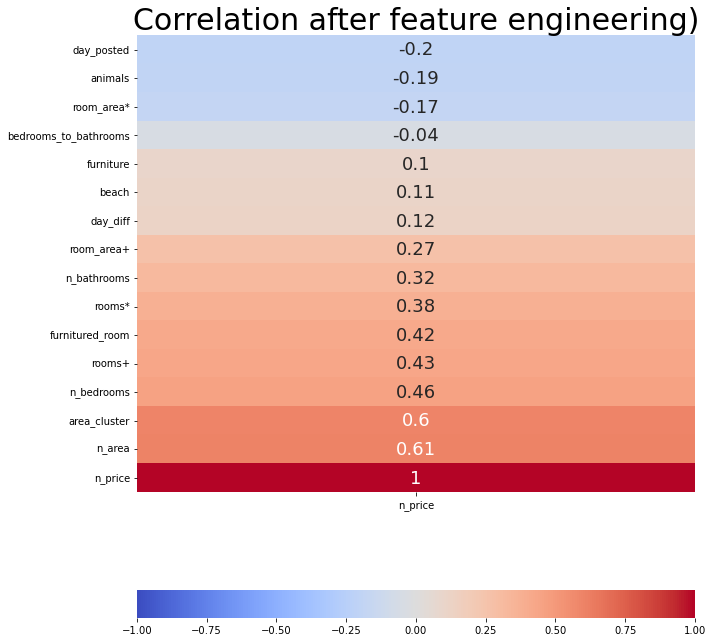

In [493]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_train.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Correlation after feature engineering)', fontsize =30)

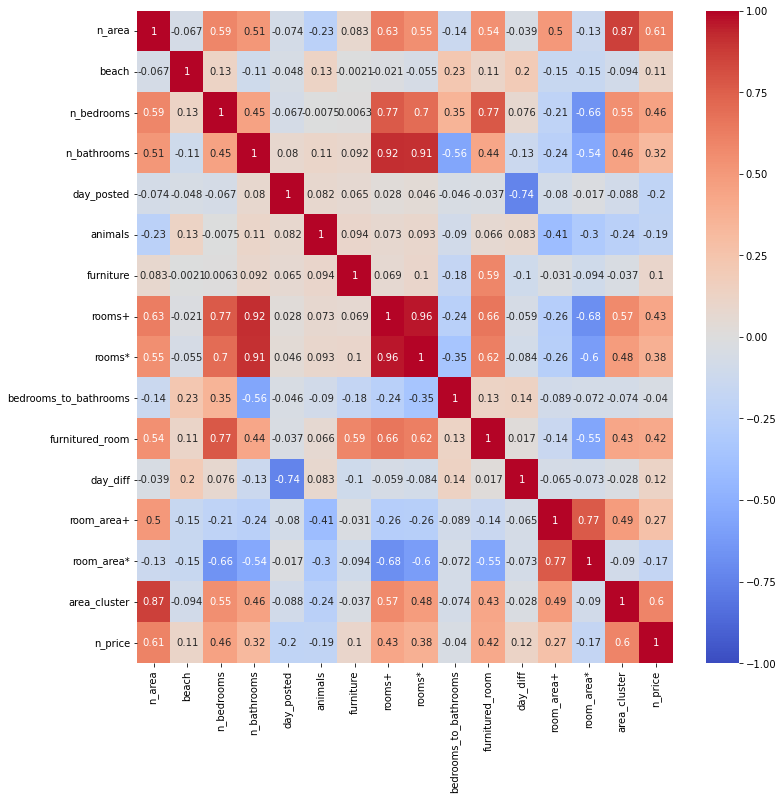

In [494]:
fig = plt.figure(figsize = (12,12))
sns.heatmap(df_train.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Lets check the features that we have already desinged: how they influence the other variables and the target feature.

n_area: as n_area increases n_price increases as well showing the positive linear corrleation with coeff of +0.73.
n_bedrooms: as n_bedrooms increases (from 1 - to 3) n_price decreases, nearly doubles peaking at three-bedroom apartments with coeff of +0.51.
n_bathrooms: no surprise bathrooms follow the bedrooms-n_price trend with +0.33 coeff.
beach_availability: places near the beach appears to be 10% more expensive than those away from the shore line.
day_posted and day_available both showed the negative correlation with n_price meaning that the early posted ads have higher rental price than those that posted later.
longitude: does not seem to have an influence onto the n_price
longitude: interesting that longitude but not latitude contributes to the n_price, as longitude goes from west to east the n_price increases. Our concern however lies mainly in Honolulu area, thus I would not take this into account yet. Lets check it later.
28% of the price decrease can be explained by the absence of laundry.
20% of the price decrease can be explained by the allowance of animals stay
Parking, furniture do not have large influence on the housing price
I will drop the columns that do not have future use: smoking, day_available. I plan to use the feature that did not show so far a significant correlation (day_posted, day_available, longitude, latitude) for future use when I can do the feature preprocessing to try to impove the correlation between those features and the target variable.

input missing values using median for the temporarily analysis for rough approximation After temporarily median imputation we got the slight drop in the n_area coefficient, which is not critical, the careful imputation will be performed later

In [495]:
df_train.head()

,n_area,beach,n_bedrooms,n_bathrooms,day_posted,animals,furniture,rooms+,rooms*,bedrooms_to_bathrooms,furnitured_room,day_diff,room_area+,room_area*,area_cluster,n_price
2856,1200.0,0,4.0,5,23,0,0,9.0,20.0,0.8,4.0,1,133.333333,60.0,4,2500
3104,798.0,0,1.0,1,23,0,0,2.0,1.0,1.0,1.0,1,399.000000,798.0,3,1995
1611,498.0,1,2.0,1,25,1,0,3.0,2.0,2.0,2.0,29,166.000000,249.0,2,1795
440,885.0,0,2.0,5,23,1,0,7.0,10.0,0.4,2.0,1,126.428571,88.5,3,2395
508,1557.0,1,3.0,3,5,0,1,6.0,9.0,1.0,6.0,19,259.500000,173.0,4,7200


In [496]:
def feature_selection_function(df_train, target):
    
    df1 = df_train.copy()

    #To select features I need to split the dataset to independent and dependent variables
    X = df1.drop(target, axis =1)
    Y = df1[target]

    #train_tets_split to ensure no data would leak to test data  
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

    #Some of the feature selection algorithms require the scaling: Lasso & Ridge regressions
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)


    print('Filter methods')


    #mutual info
    from sklearn.feature_selection import mutual_info_regression
    # determine the mutual information
    mutual_info = mutual_info_regression(X_train, y_train)
    mutual_info_series = pd.Series(mutual_info)
    mutual_info_series.index = X_train.columns
    mutual_info_series.sort_values(ascending=True).plot(kind='barh')
    plt.title('Mutual info')
    plt.show()



    #Correlation
    correlation=abs(df1.corr()[target])
    del correlation[target]
    correlation.sort_values(ascending=True).plot(kind='barh')
    plt.title('Correlation')
    plt.show()


    print('Embeded methods')

    #Lasso regression
    lasso=Lasso()
    lasso.fit(X_train_std,y_train)
    lassocoeff = pd.Series((lasso.coef_), index=df1.columns[:-1])
    lassocoeff.sort_values(ascending=True).plot(kind='barh')
    plt.title('Lasso regression')
    #plt.show()
    normLasso = lassocoeff/np.linalg.norm(lassocoeff)
    normLasso = pd.Series(abs(normLasso), index=df1.columns[:-1])
    normLasso.sort_values(ascending=True).plot(kind='barh')
    plt.title('Lasso regression')
    plt.show()


    #Ridge regression
    ridge=Ridge()
    ridge.fit(X_train_std,y_train)
    ridgecoeff = pd.Series((ridge.coef_), index=X.columns)
    ridgecoeff.sort_values(ascending=True).plot(kind='barh')

    normRidge = ridgecoeff/np.linalg.norm(ridgecoeff)
    normRidge = pd.Series(abs(normRidge), index=X.columns)
    normRidge.sort_values(ascending=True).plot(kind='barh')
    plt.title('Ridge regression')
    plt.show()


    #Elastic Net regression
    elastic=ElasticNetCV()
    elastic.fit(X_train_std,y_train)
    elasticcoeff = pd.Series((elastic.coef_), index=df1.columns[:-1])
    elasticcoeff.sort_values(ascending=True).plot(kind='barh')
    plt.title('Elastic regression')
    normelastico = elasticcoeff/np.linalg.norm(elasticcoeff)
    normelastico = pd.Series(abs(normelastico), index=df1.columns[:-1])
    normelastico.sort_values(ascending=True).plot(kind='barh')
    plt.title('Elastic regression')
    plt.show()

    # Random forest regression
    rf=RandomForestRegressor()
    rf.fit(X_train_std ,y_train)
    feat_importances2 = pd.Series(rf.feature_importances_, index=df1.columns[:-1])
    feat_importances2.sort_values(ascending=True).plot(kind='barh')
    plt.title('Random forest regression')
    plt.show()

    #Extra Trees regression
    et=ExtraTreesRegressor()
    et.fit(X_train_std ,y_train)
    feat_importances3 = pd.Series(et.feature_importances_, index=X.columns)
    feat_importances3.sort_values(ascending=True).plot(kind='barh')
    plt.title('Extra Trees regression')
    plt.show()

    #Gradient boostung regression
    gbr=GradientBoostingRegressor()
    gbr.fit(X_train_std,y_train)
    feat_importances4 = pd.Series(gbr.feature_importances_, index=X.columns)
    feat_importances4.sort_values(ascending=True).plot(kind='barh')
    plt.title('Gradient boostung regression')
    plt.show()

    #lets assign random weight to each feature
    import random
    weight2= np.random.randint(1,10)/10
    weight3= np.random.randint(1,10)/10
    weight4= np.random.randint(1,10)/10
    weight5= np.random.randint(1,10)/10
    weight6= np.random.randint(1,10)/10
    weight7= np.random.randint(1,10)/10
    weight8= np.random.randint(1,10)/10
    weight9= np.random.randint(1,10)/10
    weight10= np.random.randint(1,10)/10

    weightSum=weight2+weight3+weight4+weight5+weight6+weight7+weight8+weight9+weight10

    #Compute the average
    feat=(weight2*abs(correlation) + weight3*mutual_info + weight5*feat_importances2 + weight6*feat_importances3 + 
          weight5*feat_importances4 + weight8*normLasso + weight9*normRidge + 
          weight10*normelastico)/(weightSum)

    #plot the results of the average sum
    feat.sort_values(ascending=True).plot(kind='barh')
    plt.title('Average Feature Importance')
    plt.show()


In [497]:
df_train.columns

Index(['n_area', 'beach', 'n_bedrooms', 'n_bathrooms', 'day_posted', 'animals',
       'furniture', 'rooms+', 'rooms*', 'bedrooms_to_bathrooms',
       'furnitured_room', 'day_diff', 'room_area+', 'room_area*',
       'area_cluster', 'n_price'],
      dtype='object')

Filter methods


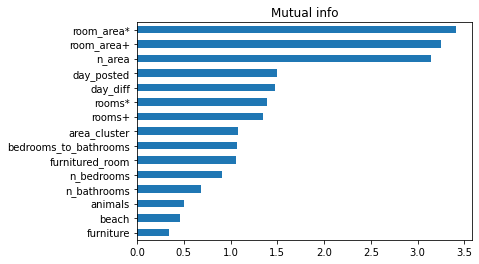

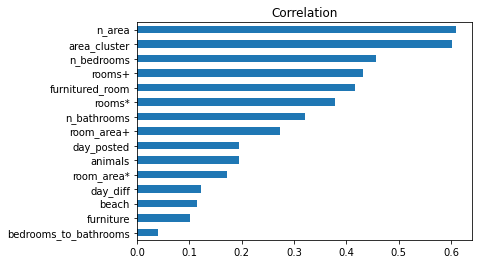

Embeded methods


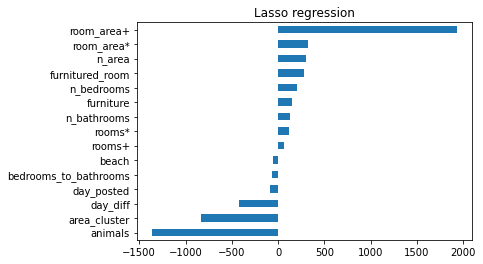

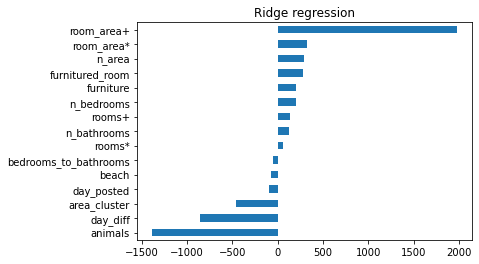

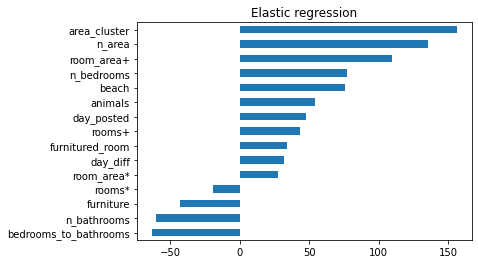

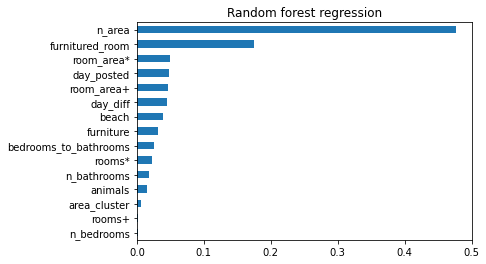

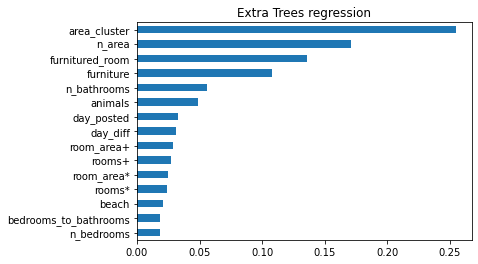

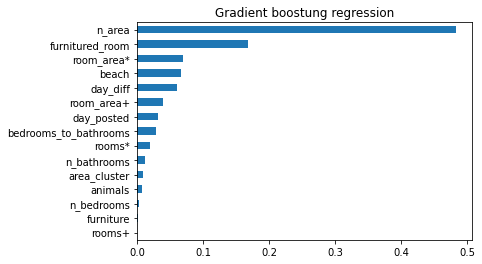

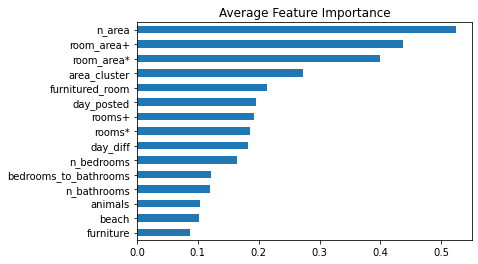

In [498]:
feature_selection_function(df_train, 'n_price')

Comparison between feature selected by correlation and all methods including correlation

It looks like tree_based model favour the new feature we created: room_area+ in contrast to correlation, which gives higher priority to just area. 

1. n_area: as n_area increases n_price increases as well showing the positive linear corrleation with coeff of +0.73.
2. n_bedrooms: as n_bedrooms increases (from 1 - to 3) n_price decreases, nearly doubles peaking at three-bedroom apartments with coeff of +0.51.
3. n_bathrooms: no surprise bathrooms follow the bedrooms-n_price trend with +0.33 coeff.
4. beach_availability: places near the beach appears to be 10% more expensive than those away from the shore line.
5. day_posted and day_available both showed the negative correlation with n_price meaning that the early posted ads have higher rental price than those that posted later.
6. longitude: does not seem to have an influence onto the n_price
7. longitude: interesting that longitude but not latitude contributes to the n_price, as longitude goes from west to east the n_price increases. Our concern however lies mainly in Honolulu area, thus I would not take this into account yet. Lets check it later.
8. 28% of the price decrease can be explained by the absence of laundry.
9. 20% of the price decrease can be explained by the allowance of animals stay
10. Parking, furniture do not have large influence on the housing price


Columns fate
1. I will drop the columns that do not have future use:
smoking, day_available.
2. I plan to use the feature that did not show so far a significant correlation (day_posted, day_available, longitude, latitude) for future use when I can do the feature preprocessing to try to impove the correlation between those features and the target variable.

Based on the averaged results from the various feature selection method we have found that apartment area might be the most important variable while predicting n_price, which is quite reasonable. Following that predictor, we can see that number of bedrooms plays a significant role there as well.

Lets verify that the features do not have multicollinearity by calculating their variable inflation factor (VIF),which must be less than 5.

In [499]:
df_train.head()

,n_area,beach,n_bedrooms,n_bathrooms,day_posted,animals,furniture,rooms+,rooms*,bedrooms_to_bathrooms,furnitured_room,day_diff,room_area+,room_area*,area_cluster,n_price
2856,1200.0,0,4.0,5,23,0,0,9.0,20.0,0.8,4.0,1,133.333333,60.0,4,2500
3104,798.0,0,1.0,1,23,0,0,2.0,1.0,1.0,1.0,1,399.000000,798.0,3,1995
1611,498.0,1,2.0,1,25,1,0,3.0,2.0,2.0,2.0,29,166.000000,249.0,2,1795
440,885.0,0,2.0,5,23,1,0,7.0,10.0,0.4,2.0,1,126.428571,88.5,3,2395
508,1557.0,1,3.0,3,5,0,1,6.0,9.0,1.0,6.0,19,259.500000,173.0,4,7200


In [500]:
df_train.columns

Index(['n_area', 'beach', 'n_bedrooms', 'n_bathrooms', 'day_posted', 'animals',
       'furniture', 'rooms+', 'rooms*', 'bedrooms_to_bathrooms',
       'furnitured_room', 'day_diff', 'room_area+', 'room_area*',
       'area_cluster', 'n_price'],
      dtype='object')

In [501]:
df_check = df_train.copy()
df_check.drop(columns=['beach', 'n_bathrooms', 'day_posted', 'animals',
       'furniture', 'bedrooms_to_bathrooms',
       'furnitured_room', 'day_diff', 'room_area+', 'room_area*',
       'area_cluster'], inplace = True)

In [502]:
df_check.columns

Index(['n_area', 'n_bedrooms', 'rooms+', 'rooms*', 'n_price'], dtype='object')

In [503]:
iv = df_check.columns[:-1]
# calculate the varience inflation factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
  
# compare with each columns 
[vif(df_check[iv].values, index) for index in range(len(iv))]  
  
# Removing multicollinearity from the datset using vif  
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
  
# compare with each columns 
for i in range(len(iv)): 
    vif_list = [vif(df_check[iv].values, index) for index in range(len(iv))]  
    maxvif = max(vif_list) 
    print("Max VIF value is ", maxvif)                       
    drop_index = vif_list.index(maxvif) 
    print("For Independent variable", iv[drop_index]) 
     
    if maxvif > 6: 
         
        print("Deleting", iv[drop_index]) 
        print()
        print()
        iv = iv.delete(drop_index) 
        print("Final Independent_variables ", iv) 

Max VIF value is  48.580253917576286
For Independent variable rooms+
Deleting rooms+


Final Independent_variables  Index(['n_area', 'n_bedrooms', 'rooms*'], dtype='object')
Max VIF value is  8.399293230597927
For Independent variable n_bedrooms
Deleting n_bedrooms


Final Independent_variables  Index(['n_area', 'rooms*'], dtype='object')
Max VIF value is  2.6104501353871945
For Independent variable n_area
Max VIF value is  2.6104501353871945
For Independent variable n_area


VIF should not exceed 5 for teh robust model. In our case it is 5.30 which tolerable because otherwise we risk t drop our n_area feature which showed the highest correlation with the target one(n_price). Based on the VIF factor we can surely omit number of bedrooms as this feature showed strong multicollinearity and would inflate the variance of the target feature during the predictions.

In [504]:
iv

Index(['n_area', 'rooms*'], dtype='object')

In [505]:
def delete_columns(df_train, iv):
    
    """
    delete columns that are in the list based on the VIF
    """
    columns_all = df_train.columns[:-1]
    columns_valid = iv.to_list()
    list_columns = set(list(columns_all)) - set(columns_valid)
    for col in list_columns:
        df_train.drop(columns = [col], inplace = True)
    return df_train


In [506]:
df_train = delete_columns(df_train, iv)
df_test = delete_columns(df_test, iv)

Based on the Feature Selection section lets get rid of less significant predictors

Filter methods


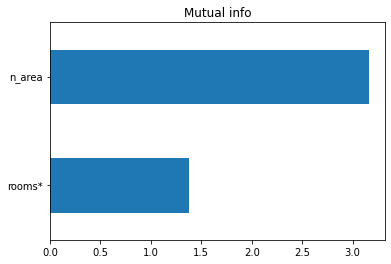

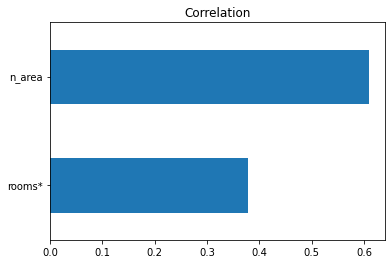

Embeded methods


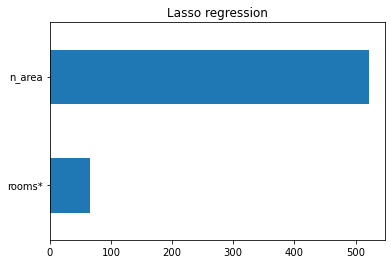

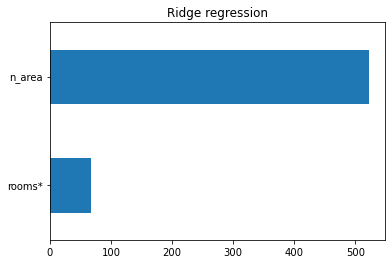

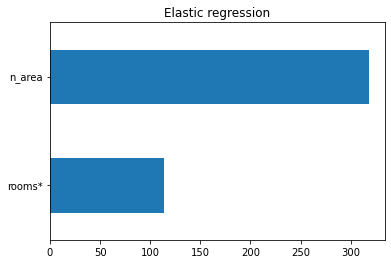

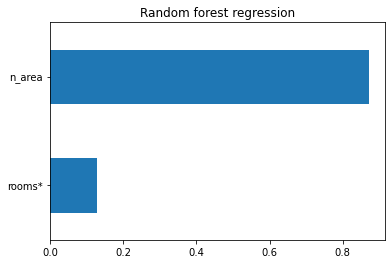

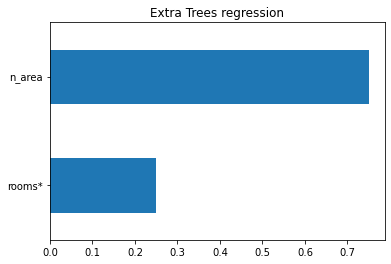

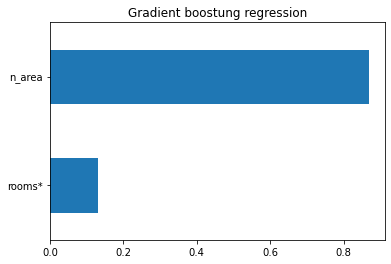

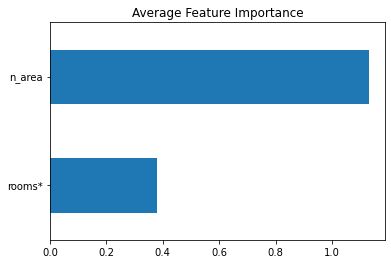

In [507]:
feature_selection_function(df_train, 'n_price')

Final assessment of the variables

In [508]:
df_train.columns

Index(['n_area', 'rooms*', 'n_price'], dtype='object')

Text(0.5, 1.0, 'Correlation after feature engineering)')

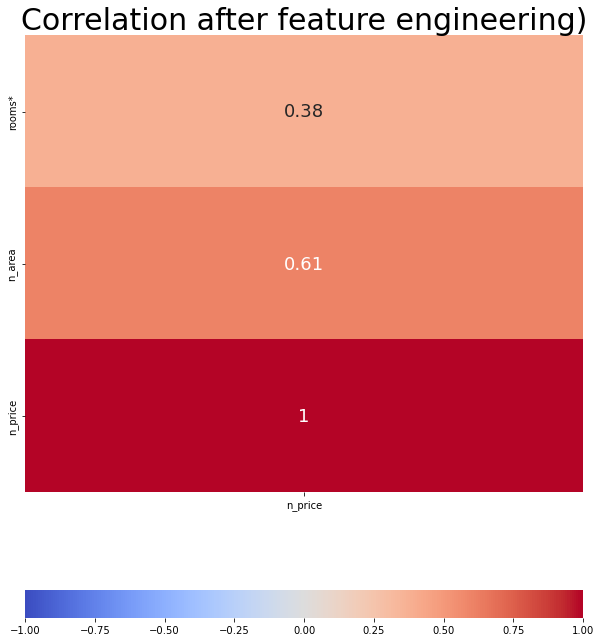

In [509]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_train.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Correlation after feature engineering)', fontsize =30)

Given the feature importance, lets delete issignificant features:


# Data preprocessing

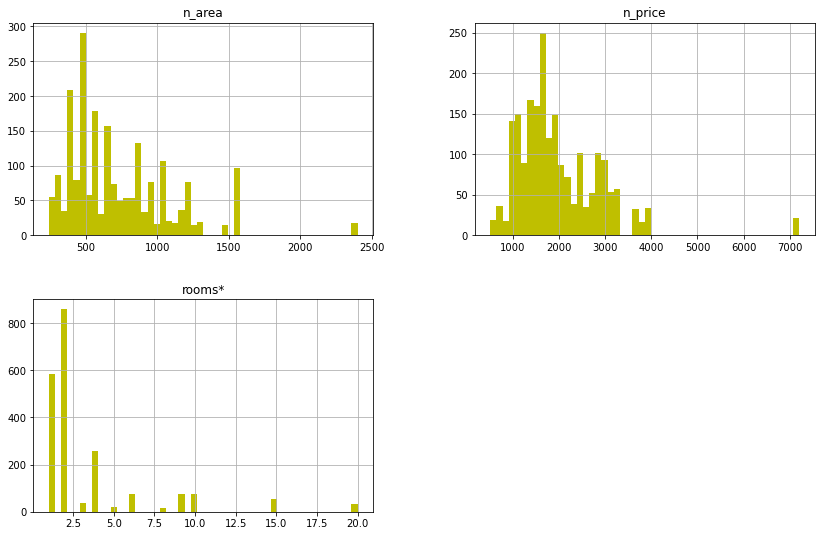

In [510]:
import matplotlib.pyplot as plt
df_train.hist(bins=50, figsize=(14,9), color = 'y')
plt.show()
    

In [511]:
df_check.columns

Index(['n_area', 'n_bedrooms', 'rooms+', 'rooms*', 'n_price'], dtype='object')

We have two continious feature here: n_price and n_area.
Other features belong to categorical environment, so we could not do anything. For those continiuos features however that do not follow the gaussian distribution, we can modify their distributions bringing as close to Gaussian shaped as possible to improve the correlation between them and target feature.

Lets start with the n_price variable

In [512]:
df_train.head()

,n_area,rooms*,n_price
2856,1200.0,20.0,2500
3104,798.0,1.0,1995
1611,498.0,2.0,1795
440,885.0,10.0,2395
508,1557.0,9.0,7200


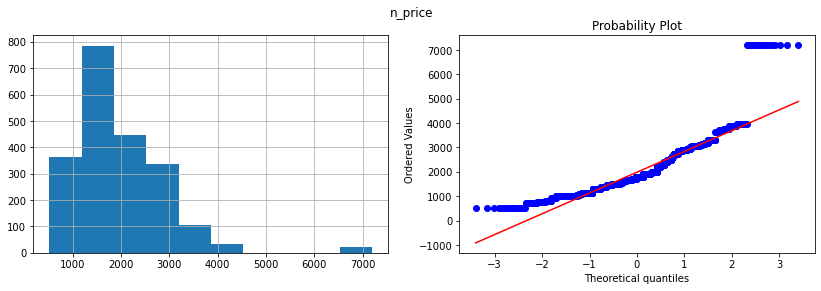

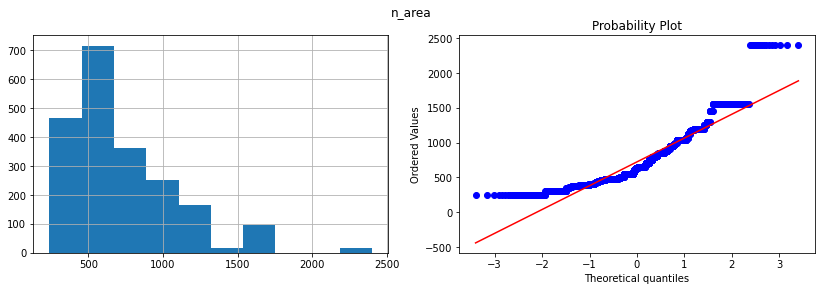

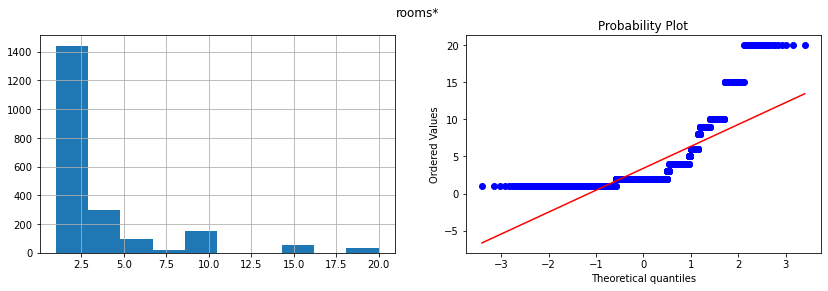

In [513]:
to_plot = ['n_price', 'n_area', 'rooms*']
from scipy import stats
from matplotlib import pylab
from pylab import *

for f in to_plot:
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    plt.suptitle(f)
    df_train[f].hist()
    plt.subplot(1,2,2)
    stats.probplot(df_train[f], dist = 'norm', plot = pylab)
    plt.show()

As we can see both variables have some outliers on the right hand site. We will deal with the outliers a bit later. For now lets modify the actual distribution, so it can mimic the gaussian one.

Lets try to convert cost_square_meter_mode to the standard normal distribution using the common transformations

1. reciprocal transformation
2. square root transformation
3. exponential transformation
4. logarithmic transformation




In [514]:
df_con = df_train.copy()
to_plot = ['n_price', 'n_area']

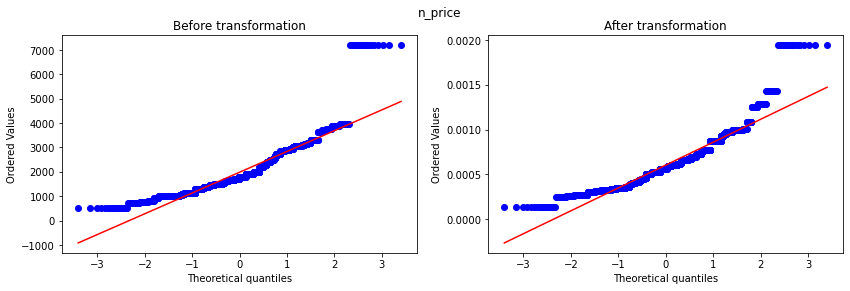

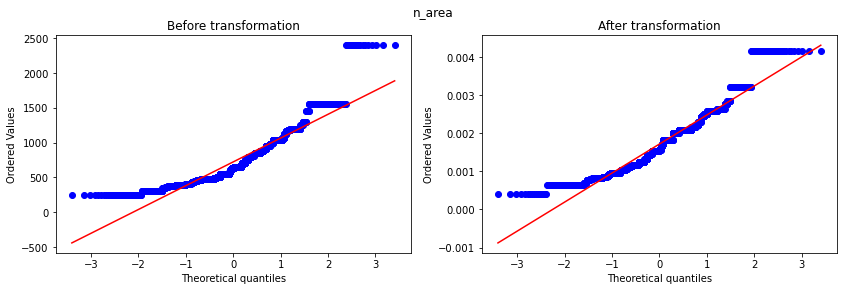

In [515]:

df = df_train.copy()
def reciprocal_trans(df):
    df_rec = pd.DataFrame()
    for f in to_plot:
        df_rec[f] = 1/df[f]
    df_rec.dropna(axis = 1, inplace = True)
    return df_rec

new_df_rec = pd.DataFrame()
new_df_rec = reciprocal_trans(df_con)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    
    
    plt.subplot(1,2,2)

    stats.probplot(new_df_rec[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()

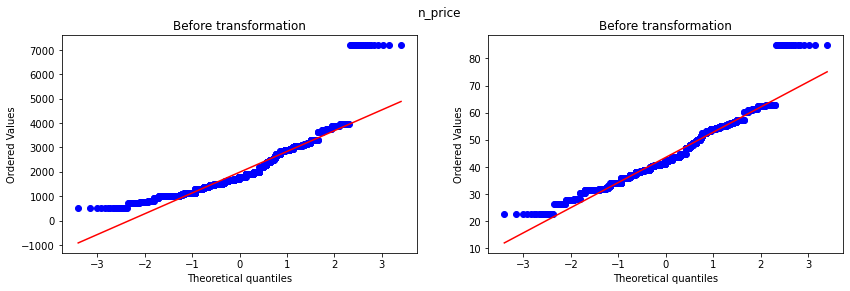

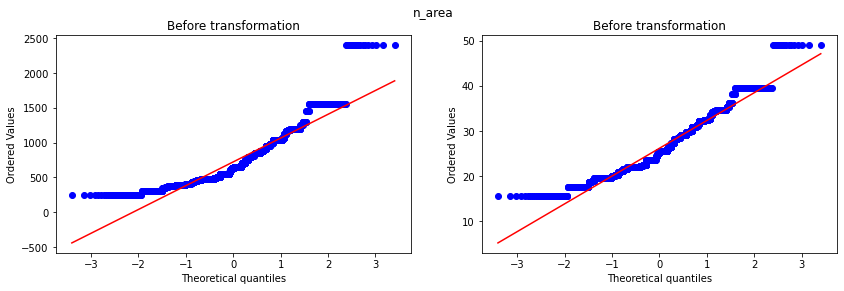

In [516]:
def sqrt_trans(df):
    df_sqrt = pd.DataFrame()
    for f in df.columns:
        df_sqrt[f] = df[f]**(1/2)
    df_sqrt.dropna(axis = 1, inplace = True)
    return df_sqrt

new_df_sqrt = sqrt_trans(df)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    
    plt.subplot(1,2,2)

    stats.probplot(new_df_sqrt[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.show()

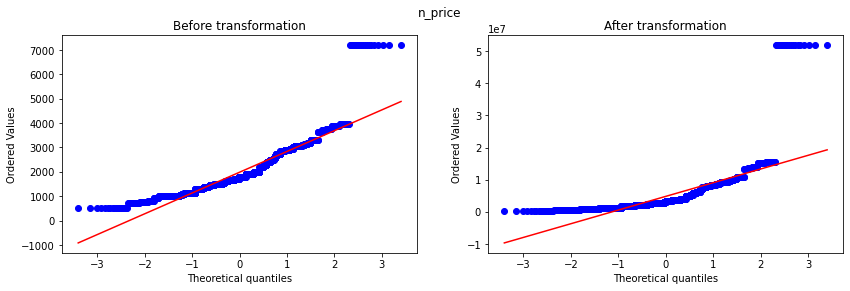

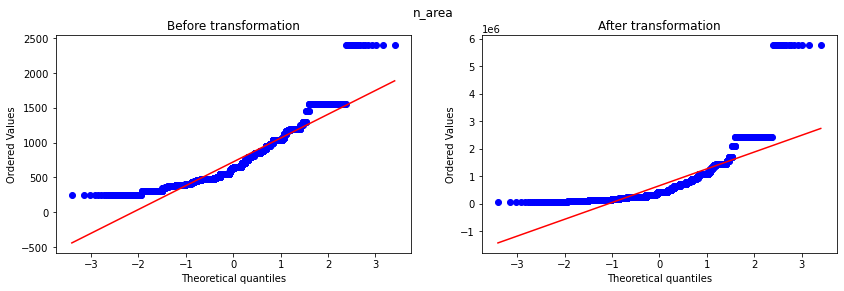

In [517]:
def exp_trans(df):
    df_exp = pd.DataFrame()
    for f in df.columns:
        df_exp[f] = df[f]**2
    df_exp.dropna(axis = 1, inplace = True)
    return df_exp

new_df_exp = exp_trans(df)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.subplot(1,2,2)

    stats.probplot(new_df_exp[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()
    

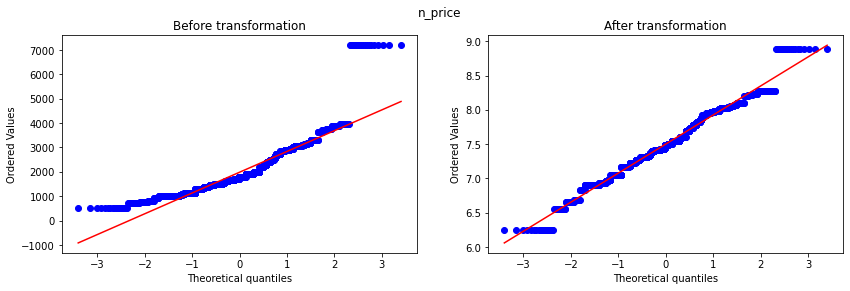

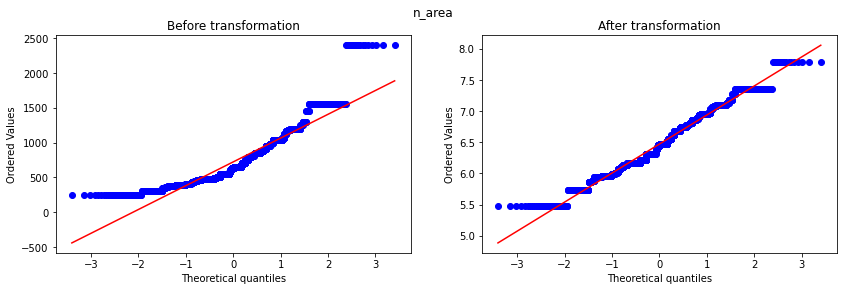

In [518]:
def log_trans(df):
    df_log = pd.DataFrame()
    for f in df.columns:
        df_log[f] = np.log(df[f])
    df_log.dropna(axis = 1, inplace = True)
    return df_log

new_df_log = pd.DataFrame()
new_df_log = log_trans(df)


for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.subplot(1,2,2)

    stats.probplot(new_df_log[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()

Only log transformation appears to be promising for and n_price features and sqrt for room_area*
Lets apply it to the df and check the correlation now


In [519]:
df_train.head()

,n_area,rooms*,n_price
2856,1200.0,20.0,2500
3104,798.0,1.0,1995
1611,498.0,2.0,1795
440,885.0,10.0,2395
508,1557.0,9.0,7200


In [520]:
df_test.head()

,n_area,rooms*,n_price
2898,385.0,2.0,1150
2976,1200.0,20.0,2500
2130,1200.0,6.0,3200
214,405.0,2.0,1299
1068,700.0,1.0,1295


In [521]:
df_train['n_price_log'] = np.log(df_train['n_price'])
df_train['n_area_log'] = np.log(df_train['n_area'])



df_test['n_price_log'] = np.log(df_test['n_price'])
df_test['n_area_log'] = np.log(df_test['n_area'])

In [522]:
df_train.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2856,1200.0,20.0,2500,7.824046,7.090077
3104,798.0,1.0,1995,7.598399,6.682109
1611,498.0,2.0,1795,7.492760,6.210600
440,885.0,10.0,2395,7.781139,6.785588
508,1557.0,9.0,7200,8.881836,7.350516


In [523]:
df_test.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2898,385.0,2.0,1150,7.047517,5.953243
2976,1200.0,20.0,2500,7.824046,7.090077
2130,1200.0,6.0,3200,8.070906,7.090077
214,405.0,2.0,1299,7.169350,6.003887
1068,700.0,1.0,1295,7.166266,6.551080


In [524]:
df_train.columns

Index(['n_area', 'rooms*', 'n_price', 'n_price_log', 'n_area_log'], dtype='object')

In [525]:
df_log = df_train[['n_area_log', 'rooms*', 'n_price_log']]

Text(0.5, 1.0, 'Log correlations')

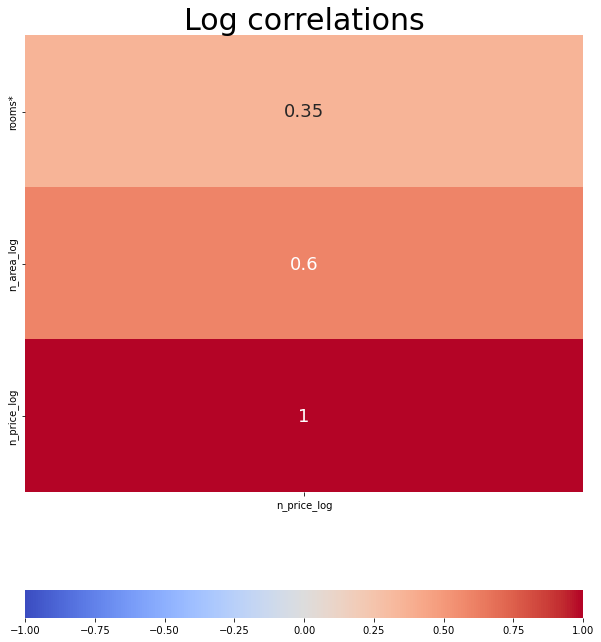

In [526]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_log.corr()[['n_price_log']].sort_values(by='n_price_log'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Log correlations', fontsize =30)

break

Filter methods


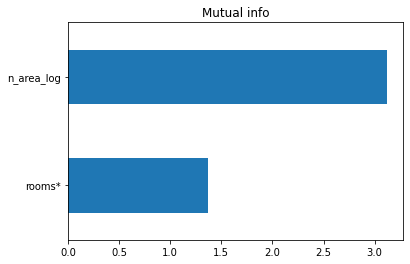

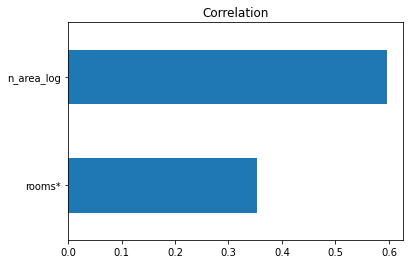

Embeded methods


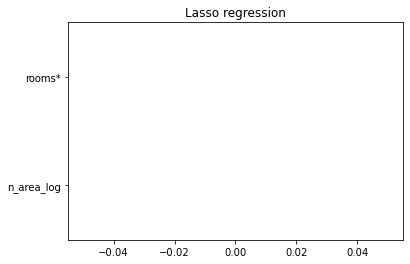

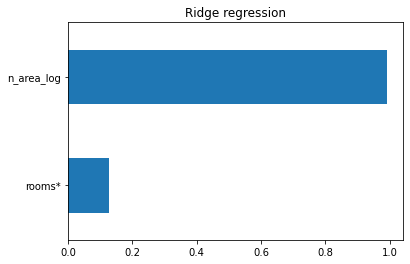

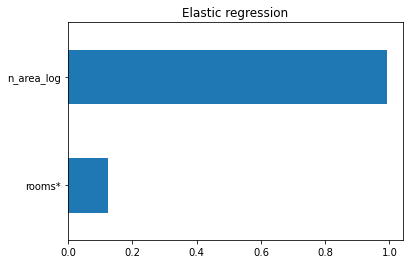

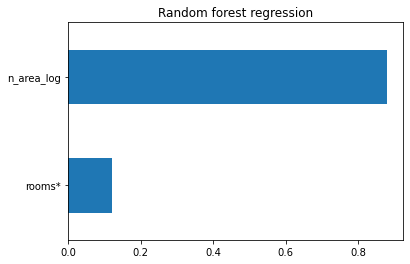

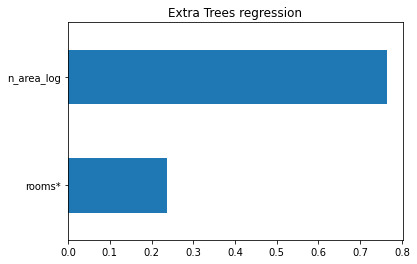

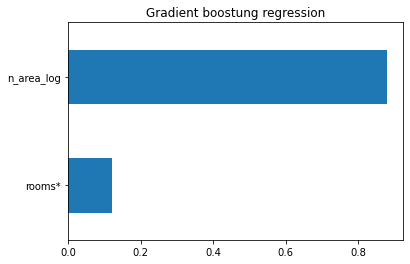

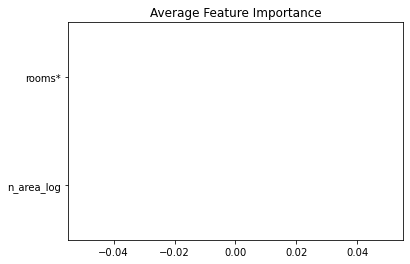

In [527]:
feature_selection_function(df_log, 'n_price_log')

Modifyng both distributions (n_area and n_price) by log transformations did not help at all

In [528]:
df_train.columns

Index(['n_area', 'rooms*', 'n_price', 'n_price_log', 'n_area_log'], dtype='object')

Lets see if we just modify only n_area

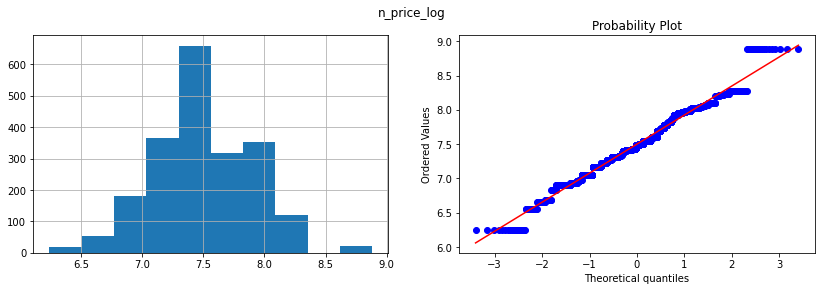

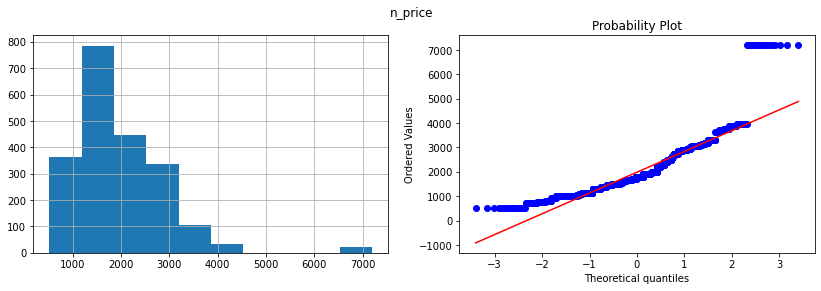

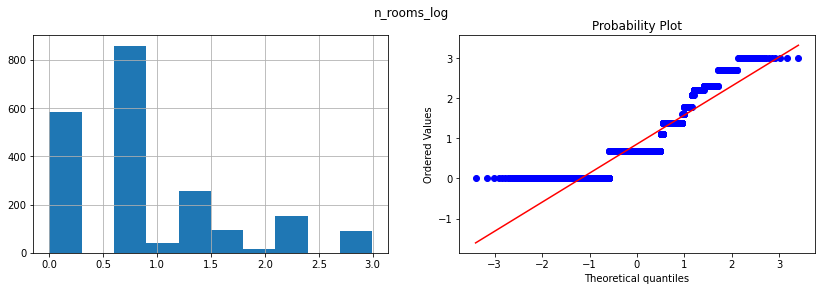

In [1468]:
to_plot = ['n_price_log', 'n_price', 'n_rooms_log']
from scipy import stats
from matplotlib import pylab
from pylab import *

for f in to_plot:
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    plt.suptitle(f)
    df_train[f].hist()
    plt.subplot(1,2,2)
    stats.probplot(df_train[f], dist = 'norm', plot = pylab)
    plt.show()

# Outliers imputation 

For regression analysis it is necessary to scale features because non-scaled features will result in biased output for models as linear regression and KNN. Tree based methods do not suffer from outliers. I plan not to delete outliers as we may lose some key data, I however will impute the outliers by the lower and upper extremes of the distribition that features have

In [529]:
df_train.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2856,1200.0,20.0,2500,7.824046,7.090077
3104,798.0,1.0,1995,7.598399,6.682109
1611,498.0,2.0,1795,7.492760,6.210600
440,885.0,10.0,2395,7.781139,6.785588
508,1557.0,9.0,7200,8.881836,7.350516


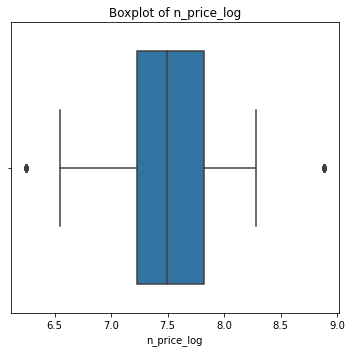

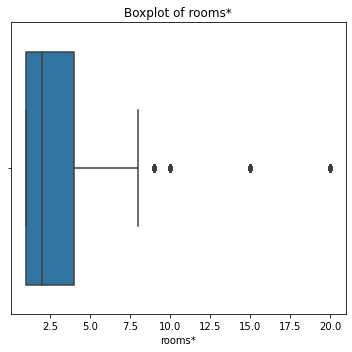

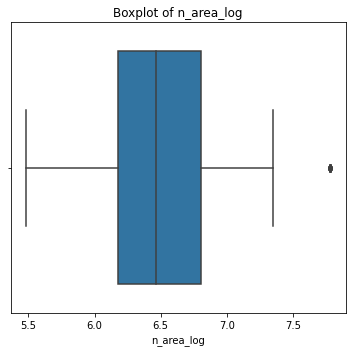

In [530]:
#Frequency of each category separated by label

feafures = ['n_price_log', 'rooms*', 'n_area_log']
#take all columns except the target Selling_Price

for f in feafures:
    plt.figure(figsize=[5,5])
    sns.boxplot(x=df_train[f])
    plt.title("Boxplot of {}".format(f))

    plt.tight_layout()
plt.show()

In [531]:
df_train.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2856,1200.0,20.0,2500,7.824046,7.090077
3104,798.0,1.0,1995,7.598399,6.682109
1611,498.0,2.0,1795,7.492760,6.210600
440,885.0,10.0,2395,7.781139,6.785588
508,1557.0,9.0,7200,8.881836,7.350516


In [532]:
df_train.columns

Index(['n_area', 'rooms*', 'n_price', 'n_price_log', 'n_area_log'], dtype='object')

In [533]:
cols = ['n_price_log', 'n_area_log']

In [534]:
def outliers_imputation(df, cols):
    """
    calculating the Interquartile range of a feature
    """
    for col in cols:
        
        IQR=df[col].quantile(0.75)-df[col].quantile(0.25)

        #calculating the borders of the normal distribution of Chance_of_Admit
        lower_bridge=df[col].quantile(0.25)-(IQR*1.5)
        upper_bridge=df[col].quantile(0.75)+(IQR*1.5)

        #Inpute the outliers with the min values that are present for the normal distribution of Chance_of_Admit
        df.loc[df[col]<=lower_bridge, col]=lower_bridge
        df.loc[df[col]>=upper_bridge, col]=upper_bridge
    
    return df

In [536]:
# lets impute outliers that are on the left side of cost_square_meter_mode_log
cols = ['n_price_log', 'n_area_log']
df_train = outliers_imputation(df_train, cols)
df_test = outliers_imputation(df_test, cols)

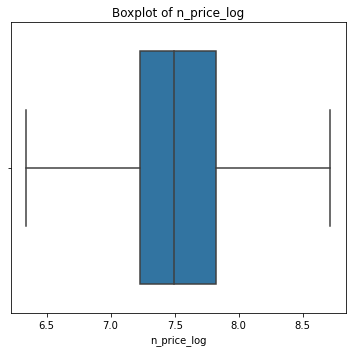

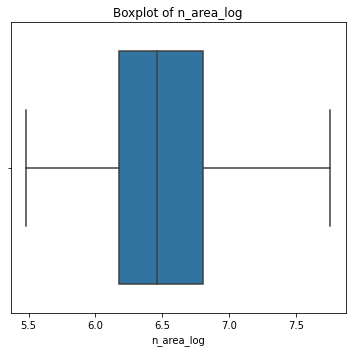

In [537]:
#Frequency of each category separated by label

feafures = ['n_price_log', 'n_area_log']
#take all columns except the target Selling_Price

for f in feafures:
    plt.figure(figsize=[5,5])
    sns.boxplot(x=df_train[f])
    plt.title("Boxplot of {}".format(f))

    plt.tight_layout()
plt.show()

In [538]:
df_train.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2856,1200.0,20.0,2500,7.824046,7.090077
3104,798.0,1.0,1995,7.598399,6.682109
1611,498.0,2.0,1795,7.492760,6.210600
440,885.0,10.0,2395,7.781139,6.785588
508,1557.0,9.0,7200,8.715357,7.350516


In [539]:
df_test.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2898,385.0,2.0,1150,7.047517,5.953243
2976,1200.0,20.0,2500,7.824046,7.090077
2130,1200.0,6.0,3200,8.070906,7.090077
214,405.0,2.0,1299,7.169350,6.003887
1068,700.0,1.0,1295,7.166266,6.551080


# Feature Scaling 

In [540]:
df_train.dtypes

n_area         float64
rooms*         float64
n_price          int32
n_price_log    float64
n_area_log     float64
dtype: object

In [541]:
def visualizing_scaled_features(df):
    """
    visualizing the scaled features
    """
    
    # select numeric columns
    df_numeric = df.select_dtypes(include=[np.float])
    numeric_cols = df_numeric.columns.values
    numeric_cols
    
    from sklearn import preprocessing
    for col in numeric_cols:

        np.random.seed(1)
        scaler = preprocessing.StandardScaler()
        scaled_df_2 = scaler.fit_transform(df[col].values.reshape(-1, 1))
        scaled_df = pd.DataFrame(scaled_df_2, columns=[col])
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 2))
        ax1.set_title('Before Scaling')
        sns.kdeplot(df[col], ax=ax1)

        ax2.set_title('After Standard Scaler')
        sns.kdeplot(scaled_df[col], ax=ax2, color = 'y')
        plt.show()

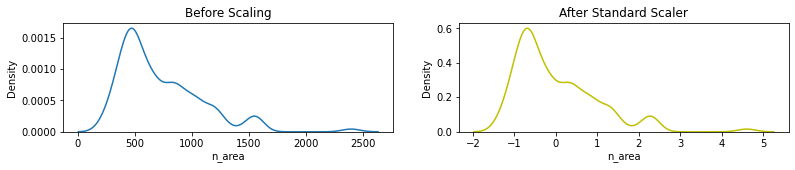

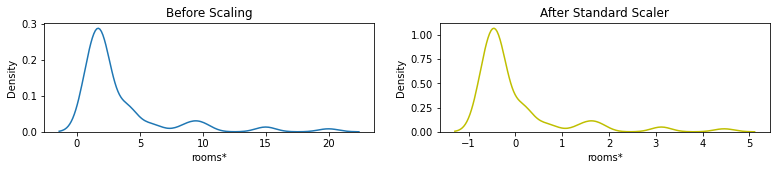

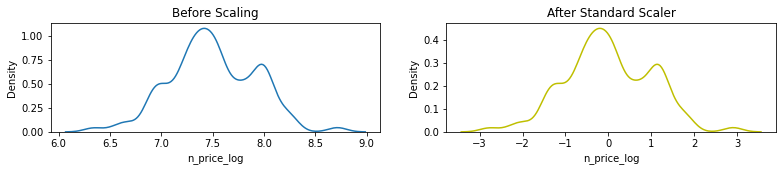

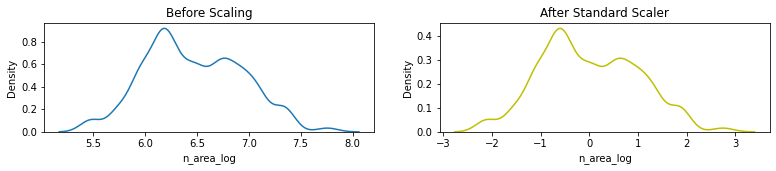

In [542]:
visualizing_scaled_features(df_train)

The same transformations must be done for the Test df

In [543]:
df_train.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2856,1200.0,20.0,2500,7.824046,7.090077
3104,798.0,1.0,1995,7.598399,6.682109
1611,498.0,2.0,1795,7.492760,6.210600
440,885.0,10.0,2395,7.781139,6.785588
508,1557.0,9.0,7200,8.715357,7.350516


In [544]:
df_test.head()

,n_area,rooms*,n_price,n_price_log,n_area_log
2898,385.0,2.0,1150,7.047517,5.953243
2976,1200.0,20.0,2500,7.824046,7.090077
2130,1200.0,6.0,3200,8.070906,7.090077
214,405.0,2.0,1299,7.169350,6.003887
1068,700.0,1.0,1295,7.166266,6.551080


In [545]:
y_train.head()

2856    2500
3104    1995
1611    1795
440     2395
508     7200
Name: n_price, dtype: int32

In [546]:
y_test.head()

2898    1150
2976    2500
2130    3200
214     1299
1068    1295
Name: n_price, dtype: int32

In [547]:
df = pd.concat([df_train, df_test], axis = 0)

In [548]:
df.shape

(3120, 5)

In [549]:
df.columns

Index(['n_area', 'rooms*', 'n_price', 'n_price_log', 'n_area_log'], dtype='object')

In [550]:
df = df[['rooms*', 'n_area_log', 'n_price_log']]

In [551]:
# preparing data for the train_test_split
X = df.iloc[:,:-1]
Y = df.iloc[:, -1]

In [552]:
# splitting data into test and train splits
from sklearn.model_selection import train_test_split

# split data into test (20%) and train (80%) parts
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2496, 2)
x test:  (624, 2)
y train:  (2496,)
y test:  (624,)


In [553]:
# features scaling
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

print('X_train: ', X_train_st)
print()
print('X_test: ', X_test_st)

X_train:  [[-0.36861045 -1.54939008]
 [-0.36861045 -1.09673648]
 [-0.36861045 -1.54939008]
 ...
 [-0.36861045 -0.83779942]
 [-0.36861045 -0.83292996]
 [-0.64210977 -2.09896494]]

X_test:  [[ 0.17838817  1.00245042]
 [ 0.17838817  1.00245042]
 [-0.64210977 -0.6290425 ]
 ...
 [ 0.17838817  0.18314995]
 [-0.36861045 -1.54939008]
 [-0.36861045 -1.12445779]]


# Model selection 

In [554]:
# creating a dictionary of the models (estimators) 
estimators = {
    'Linear Regression': [LinearRegression()],
    'Lasso' :[Lasso()],
    'Ridge' :[Ridge()],
    'KNN' :[KNeighborsRegressor()],
    'Decision Tree' :[DecisionTreeRegressor()],
    'Ransom Forest' :[RandomForestRegressor()],
    'XG Boost': [XGBRegressor()],
}

# writing a function to fit models above to the train dataset
def mfit(estimators, X_train_st, y_train):
    for m in estimators:
        estimators[m][0].fit(X_train_st, y_train)
        print(m+' fitted')

mfit(estimators, X_train_st, y_train)

Linear Regression fitted
Lasso fitted
Ridge fitted
KNN fitted
Decision Tree fitted
Ransom Forest fitted
XG Boost fitted


In [555]:
import sklearn.metrics as metrics

# applying the fitted models to the test dataset
def mpredict(estimators, X_test_st, y_test):
    outcome = dict()
    for m in estimators:
        y_pred = estimators[m][0].predict(X_test_st)
        outcome[m] = [round(metrics.r2_score(y_test, y_pred), 2), 
                      metrics.mean_absolute_error(y_test, y_pred),
                     
                     metrics.mean_squared_error(y_test, y_pred),
                     np.sqrt(metrics.mean_squared_error(y_test, y_pred))]
    return outcome

outcome = mpredict(estimators, X_test_st, y_test)

From the selected metrics I would choose MAE because it is better describes the relationship between the price and rooms number

In [556]:
#printing the regression errors as metrics for the model evaluation
for m in outcome:
    print('------------------------'+m+'------------------------')
    print('R2 score', round(outcome[m][0],2))
    
    
    
    print('MAE', round(outcome[m][1],2))
    print( )

    print('MSE', round(outcome[m][2],2))
    print('RMSE', round(outcome[m][3],2))

------------------------Linear Regression------------------------
R2 score 0.31
MAE 0.24

MSE 0.12
RMSE 0.34
------------------------Lasso------------------------
R2 score -0.0
MAE 0.33

MSE 0.17
RMSE 0.42
------------------------Ridge------------------------
R2 score 0.31
MAE 0.24

MSE 0.12
RMSE 0.34
------------------------KNN------------------------
R2 score 0.64
MAE 0.11

MSE 0.06
RMSE 0.25
------------------------Decision Tree------------------------
R2 score 0.64
MAE 0.11

MSE 0.06
RMSE 0.25
------------------------Ransom Forest------------------------
R2 score 0.65
MAE 0.11

MSE 0.06
RMSE 0.25
------------------------XG Boost------------------------
R2 score 0.64
MAE 0.11

MSE 0.06
RMSE 0.25


In [1495]:
df1['n_price'].min()

515

In [1496]:
df1['n_price'].max()

7200

# Hyperparameter tuning 



Randomized search CV

As Random Forest so far is the best model for the regression task, lets try to improve the R2 factor and reduce the errors.

In [557]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

In [558]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [559]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [560]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_st, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [561]:
# checking best hyperparameters
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [562]:
def evaluate(model, X_test_st, y_test):
    """
    checking the model accuracy
    """
    predictions = model.predict(X_test_st)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [568]:
# checking the model accuracy

base_model = RandomForestRegressor(n_estimators= 600, random_state = 42)

base_model.fit(X_train_st, y_train)
base_accuracy = evaluate(base_model, X_test_st, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_st, y_test)

Model Performance
Average Error: 0.1073 degrees.
Accuracy = 98.54%.
Model Performance
Average Error: 0.1088 degrees.
Accuracy = 98.52%.


In [569]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.02%.


Check it for Random Forest regressor

In [573]:
# for Random Forest with the best hyperparameters
rf = RandomForestRegressor(n_estimators= 600,min_samples_split= 2,min_samples_leaf= 4,
                           max_features= 'auto',max_depth= 40, bootstrap= True, random_state = 42)

# fir train data to the model
rf.fit(X_train_st, y_train)

# find predictions
predictions = rf.predict(X_test_st)

In [574]:
from sklearn.model_selection import cross_val_score

#calculate cross validated R2
R2 = cross_val_score(rf, X=X_train_st, y=y_train,cv=10, scoring='r2').mean()  

#display adjusted R-squared
#calculate Adj R2
n= len(X_train)
p = len(X_train.columns)
adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1))

MAE: 0.1087453967266849
MSE: 0.0598158660230475
RMSE: 0.24457282355782603
R2 score = 0.65
adjR2 score = 0.73


Comparing to the Random Forest Regressor without hyperparameters tuning, we can clearly see that our model has significantly improved:
R2 score increased by 0.02
MAE and MSE decreased, but RMSE increased


What metrics do we plan to use for the model evaluation?
Do outliers play a decisive role here?

In this regression case, I would opt for the MAE error, because the price is mostly proportional to the predictors. For example, as n_area increases by certain number, the price increases as well to some certain number. Regarding the alternative metric: RMSE metric could be very helpful in case of clinical trial or drug dosage analysis, where the change in dosage does not have this kind of proportionality and effect become evident once the critical border would be passed. Here we have not detected the exponential and other correlation. Even for the linear model we know that with 0.64 coeff (n_area vs n_price) as n_area increases by 1 , n_price increases by 0.64.

88% of the n_price variance can be explained by 4 features ('beach_availability', 'n_area_random', 'n_bathrooms', 'day_diff')

Lets see the distribution between the predictions we have made and the actual distribution of the true n_price variables obtained from the test dataset

In [576]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,3.27

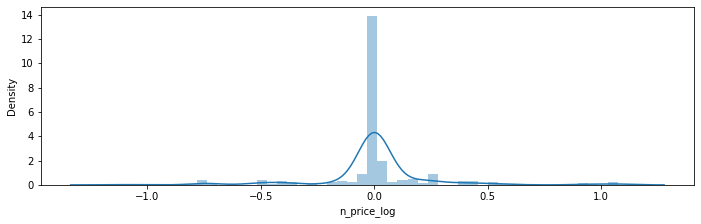

In [577]:
import seaborn as sns
sns.distplot(y_test-predictions)

Even though the predicted data resulted in some outliers, overall distribution look satisfactory.

Now we can take a look at how the Random Forest Regressor works to get us to the right answer. We can visualize the whole process of constructing a decision tree from the beginning.

# Conclusion

It looks like the linear regression model did not pass required tests, thus must be discarded. We however will continue with the model obtained the Random Forest Regressor

In [580]:
df.shape

(3120, 3)

In [581]:
df.to_csv(r'C:\Users\valer\Desktop\Projects\honolu\for_pickle.csv')